# **Time Series Homework 2**

Edward Anderson

**Honor Pledge**: On my honor as a student, I have neither given nor received any unauthorized aid on this assignment. - Edward Anderson

In [134]:
# Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

## **QUESTION 1: Show a data description.**
1. Provide a summary of the data set to include descriptive statistics.
2. Plot the time series.
3. (optional) Provide any additional plots that may show important characteristics of your data

In [135]:
# Load & Preprocess Data
sales = pd.read_csv('data/sales_data.csv')
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
sales['qty'] = pd.to_numeric(sales['qty'], errors='coerce')
sales['val'] = pd.to_numeric(sales['val'], errors='coerce')
# Subset and Group
sales = sales[~sales['world'].isin(['gr', 'na'])]
sales = sales.groupby('date').sum().reset_index().drop(columns=['world'])
sales.sort_values('date', inplace=True)
# Correct sales anaomaly
sales.rename(columns={'qty' : 'order_quantity', 'val' : 'order_value'}, inplace=True)
sales.loc[sales['order_quantity'].idxmax(), 'order_quantity'] = sales.loc[sales['order_quantity'].idxmax() - 1, 'order_quantity']
sales.loc[sales['order_value'].idxmax(), 'order_value'] = sales.loc[sales['order_value'].idxmax() - 1, 'order_value']
# Group by Week
sales['date'] = sales['date'].dt.to_period('W').apply(lambda r: r.start_time)
sales = sales.groupby('date').sum().reset_index()
print(sales.head())

        date  order_quantity  order_value
0 2018-01-01           474.0    1147036.0
1 2018-01-08           492.0    1153592.0
2 2018-01-15           852.0    2301456.0
3 2018-01-22           756.0    1933800.0
4 2018-01-29           822.0    2020556.0


In [136]:
# Descriptive Stats and EDA
print("Basic Descriptive Statistics:")
sales.describe().style.format("{:,.0f}", subset=['order_quantity', 'order_value'])

Basic Descriptive Statistics:


,date,order_quantity,order_value
count,419,419,419
mean,2022-01-09 04:21:11.599045120,"2,914","6,472,871"
min,2018-01-01 00:00:00,474,"1,147,036"
25%,2020-01-02 12:00:00,"1,530","3,588,158"
50%,2022-01-10 00:00:00,"2,508","5,871,536"
75%,2024-01-18 12:00:00,"3,783","8,573,088"
max,2026-01-19 00:00:00,"16,116","21,200,652"
std,nan,"2,007","3,732,091"


The table above shows the descriptive stats of these data. For this assignment, I will be modeling order quantity. These data are weekly, so the date represents the first day of each week. The mean order quantity is ~2900 units, the max is ~16,000, and the minimum is 474. These data are highly variable with a standard deviation of ~2,000 units. Finally, we have plenty of data points (419 weeks) which is enough to detect patterns, trends, and seasonality in the data. 

In [137]:
# Plot Sales Qty Over Time
plot = px.line(sales, x='date', y='order_quantity', 
               hover_data=['order_quantity'], 
               labels={'order_quantity':'Sales Quantity', 
                       'date':'Date'})
plot.update_layout(title='Sales Over Time')
plot.show()

# Plot Sales Value
plot = px.line(sales, x='date', y='order_value', 
               hover_data=['order_value'], 
               labels={'order_value':'Sales Value', 
                       'date':'Date'})
plot.update_layout(title='Sales Value Over Time')
plot.show()

Based on these plots, there appears to be weak yearly seasonality, and a weak trend as well. 

In [138]:
# FUCNTIONS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def diagnostic_plot(series, title="Time Series"):
    '''Plot Time Series, ACF, PACF, and Histogram for a given series.'''
    plt.style.use('ggplot')
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    fig.suptitle(f'Diagnostic Plots: {title}', fontsize=16, fontweight='bold')
    # Time series plot
    ax[0,0].plot(series, linewidth=1.5, color='darkblue')
    ax[0,0].set_title('Original Time Series', fontweight='bold')
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('Value')
    ax[0,0].grid(True, alpha=0.3)
    # ACF plot
    plot_acf(series, lags=min(60, len(series)//2), ax=ax[0,1], alpha=0.05)
    ax[0,1].set_title('Autocorrelation Function (ACF)', fontweight='bold')
    # PACF plot
    plot_pacf(series, lags=min(60, len(series)//2), ax=ax[1, 0], 
              alpha=0.05, method='ywm')
    ax[1, 0].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')
    
    # Histogram
    ax[1, 1].hist(series, bins=30, density=True, alpha=0.7, 
                    color='darkblue', edgecolor='black')
    ax[1, 1].set_title('Distribution', fontweight='bold')
    ax[1, 1].set_xlabel('Value')
    ax[1, 1].set_ylabel('Density')
    ax[1, 1].grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

from statsmodels.tsa.stattools import adfuller, kpss
def adf_test(series):
    '''Function to perform ADF test on series and print results.'''
    result = adfuller(series)
    print("ADF TEST RESULTS:")
    print('   ADF Statistic: {:.4f}'.format(result[0]))
    print('   p-value: {:.4f}'.format(result[1]))
    if result[1] < 0.05:
        print("Conclusion: Reject Null Hypothesis -- Series is Stationary")
    else:
        print("Conclusion: Fail to Reject Null Hypothesis -- Series is Non-Stationary")
def kpss_test(series):
    '''function to perform KPSS test on series and print results...'''
    result = kpss(series)
    print("KPSS TEST RESULTS:")
    print('   KPSS Statistic: {:.4f}'.format(result[0]))
    print('   p-value: {:.4f}'.format(result[1]))
    if result[1] < 0.05:
        print("   Conclusion: Reject Null Hypothesis -- Series is Non-Stationary")
    else:
        print("   Conclusion: Fail to Reject Null Hypothesis -- Series is Stationary")
        
from statsmodels.stats.diagnostic import acorr_ljungbox
def ljung_box_test(series, lags=10):
    '''function to perform LB test on series and print results'''
    result = acorr_ljungbox(series, lags=lags, return_df=True)
    print("Ljung-Box Test Results: PVal < .05 means we reject the null and there IS autocorrelation in the data")
    return result.style.format("{:.5f}", subset=['lb_stat', 'lb_pvalue'])

from statsmodels.tsa.seasonal import STL
def stl_decomposition(series, series_name, period):
    '''function to perform STL decompose and plot results'''
    stl = STL(series, period=period)
    result = stl.fit()
    fig = result.plot()
    fig.suptitle(f'STL Decomposition of {series_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

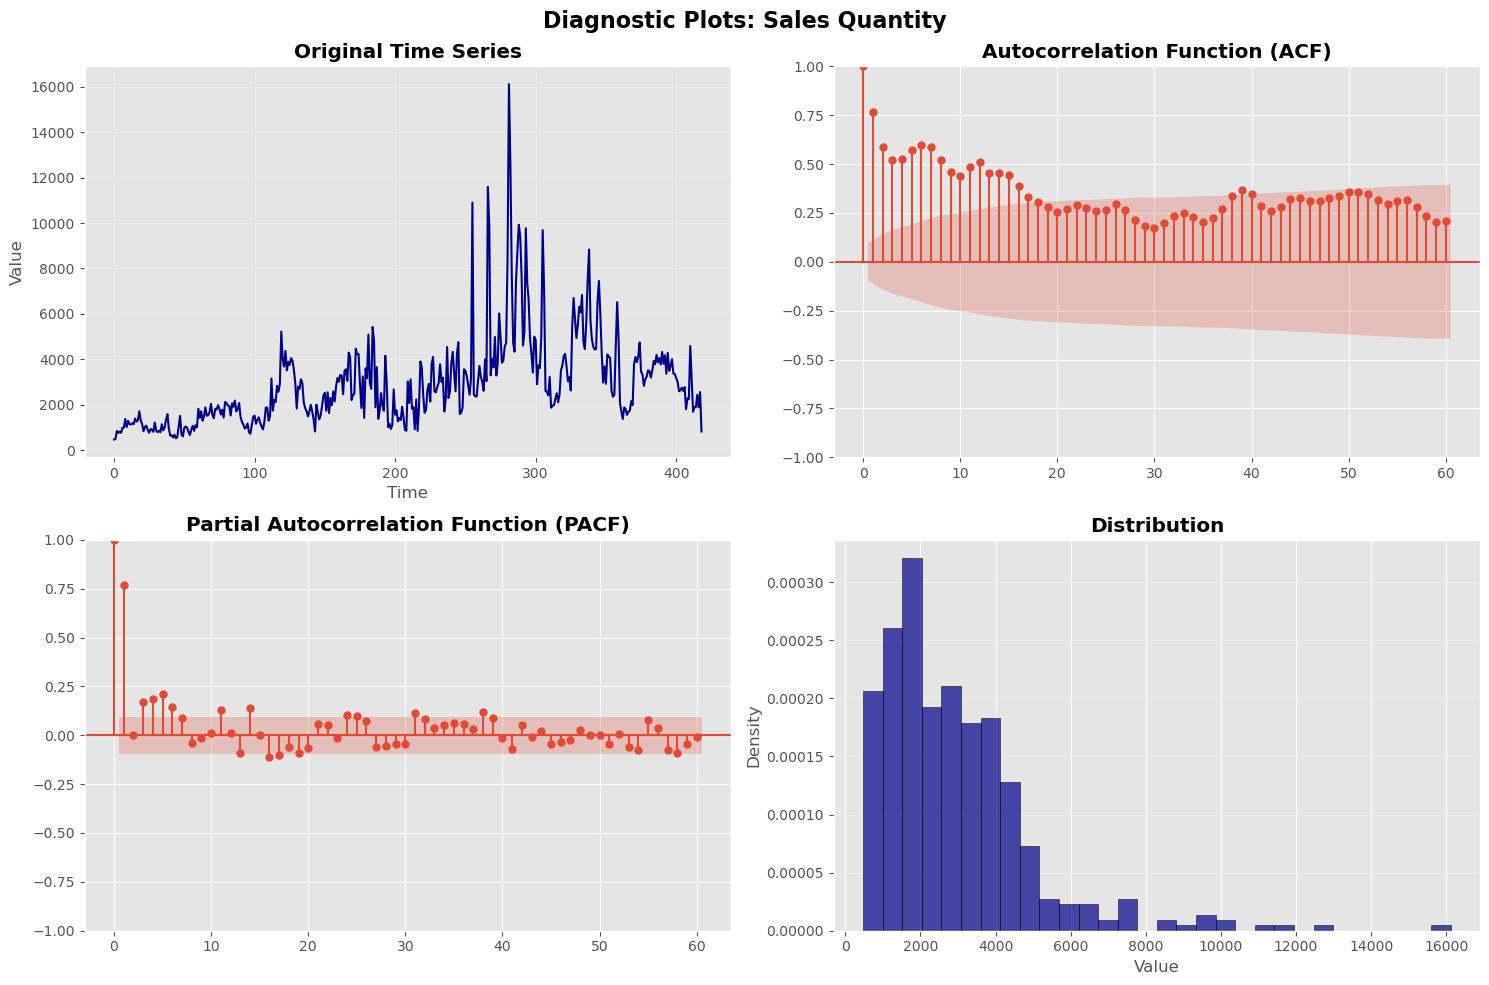

In [139]:
# Plot Diagnostic Plots -- SALES QUANTITY
diagnostic_plot(sales['order_quantity'], title='Sales Quantity')

The autocorrelation plot slowly decreases, which is a sign of non stationarity. The PACF shows a significant spike at lag 1 and then quickly drops off, which suggests that AR(1) *could* be appropriate for this data. Before we do any modeling, however, I need to ensure that the data is stationary (I don't believe that it is given the ACF plot...).

---

## **QUESTION 2**: (45 points): Apply Box Jenkins Methodology using ARIMA, SARIMA, or SARIMAX depending on your data to obtain and evaluate forecasts. 
1. *Identification*: Perform all the necessary steps for identification and include automatic and manual identification. Summarize the results from your identification process. 
2. *Estimation*: Perform all necessary steps for identification and summarize the results of your estimation process.
3. *Diagnostic Checking*: Perform all necessary steps for diagnostic checking and summarize the results of your diagnostic checking process.
4. *Forecasting*: Compare the performance of the forecasts of your selected models using the appropriate methods on a test data set. Show graphics of the forecast performance to include confidence intervals. Describe your results and conclusions about the usefulness of the models you evaluated to forecast in the application domain of the data set.

### **Part A: Identification**

To identify the appropriate model(s) (and AR / MA orders), I will use ACF / PACF plots, the ADF test, the KPSS test, and the auto_arima function. 

ACF / PACF Plots for Sales Quantity: (SAME AS ABOVE)


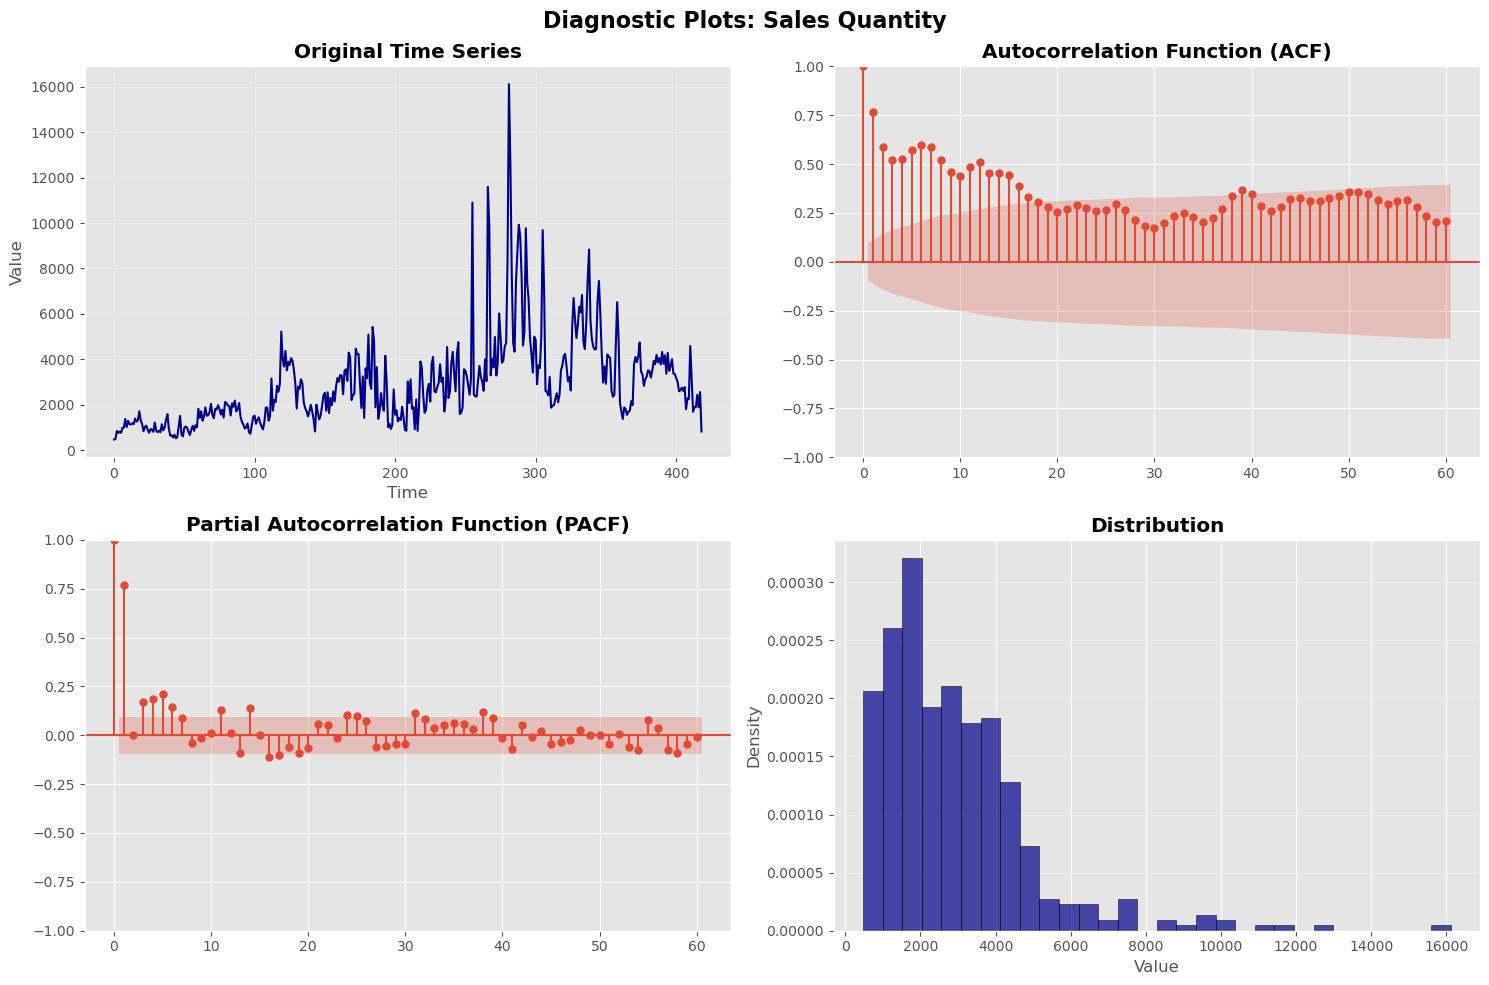

In [140]:
# Plot Diagnostics
print("ACF / PACF Plots for Sales Quantity: (SAME AS ABOVE)")
diagnostic_plot(sales['order_quantity'], title='Sales Quantity')

Based on the ACF plot, there is a slow decay of autocorrelations at lags 1-60, which is a strong sign of non-stationarity. The PACF plot shows a significant spike at lag 1 and then quickly drops off; however, some of the lags after lag 1 are also significant. The spike at lag 1 suggests that AR(1) could be appropriate for the data. The data likely needs to be differenced, so I will assess the PACF and ACF plots after differencing to determine the appropriate AR and MA orders.

In [141]:
adf_test(sales['order_quantity']); print("\n")
kpss_test(sales['order_quantity'])

ADF TEST RESULTS:
   ADF Statistic: -2.9045
   p-value: 0.0448
Conclusion: Reject Null Hypothesis -- Series is Stationary


KPSS TEST RESULTS:
   KPSS Statistic: 1.7403
   p-value: 0.0100
   Conclusion: Reject Null Hypothesis -- Series is Non-Stationary


/tmp/ipykernel_1858/1655461131.py:45: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The ADF test and KPSS test conflict with each other. They both reject the null hypothesis. For ADF, this teams that the data are stationary, but for the KPSS test, this means that the data are nonstationary. The P-Value for the ADF test is close to .05, however, so it barely rejects the null hypothesis. Given the ACF plot, I do not believe these data to be stationary, so I will difference the data, and then reassess these diagnostics.  

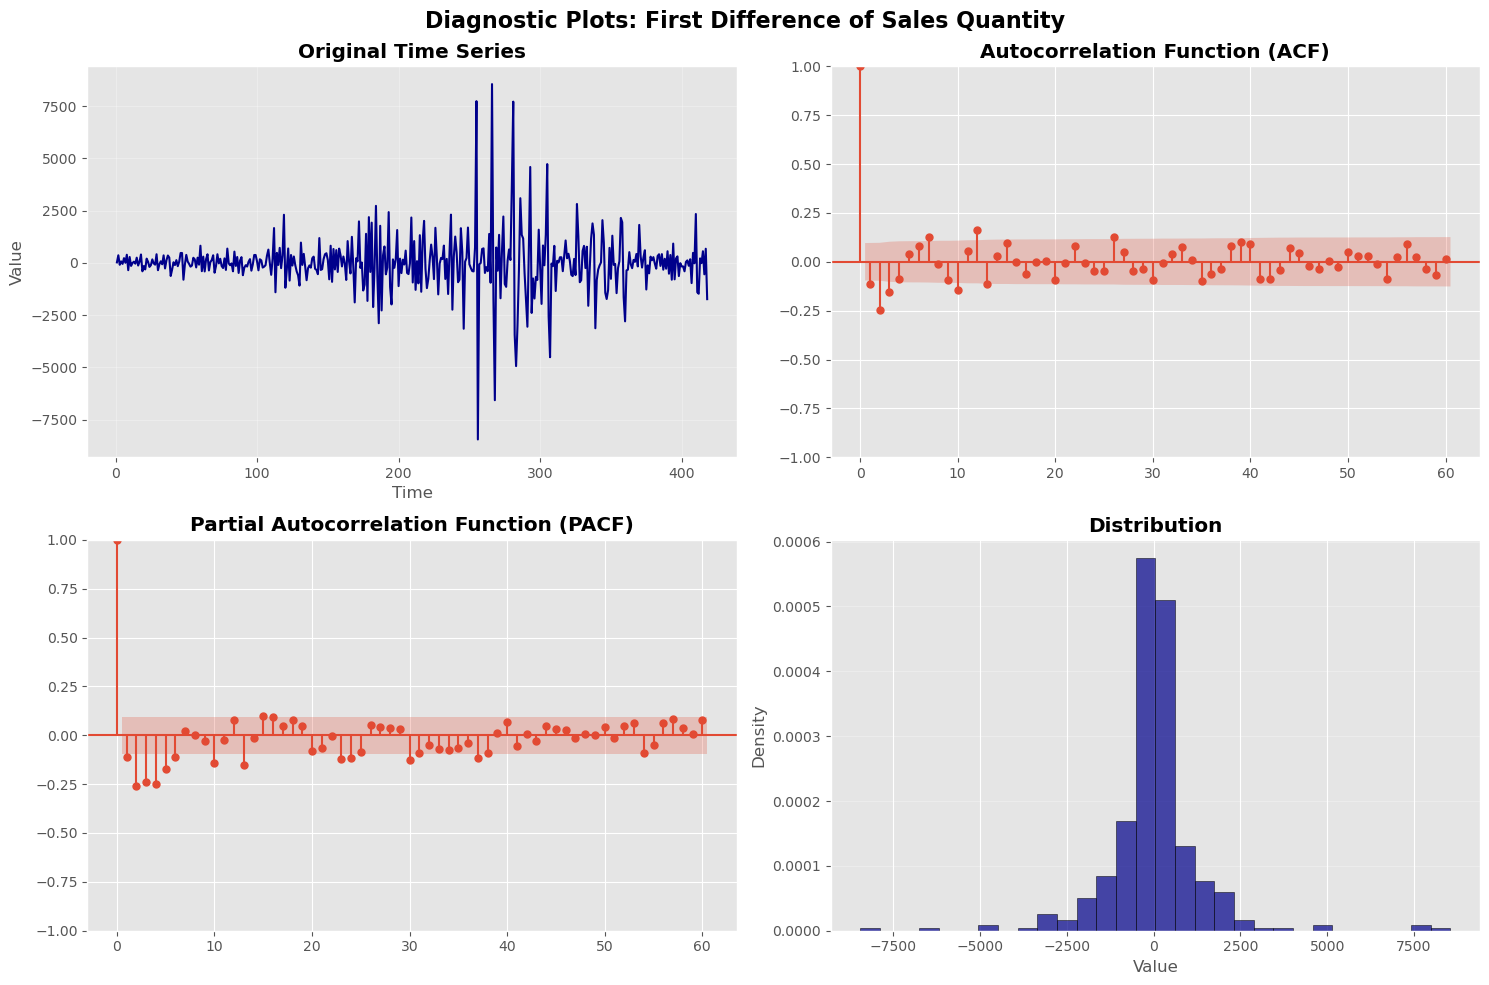

ADF TEST RESULTS:
   ADF Statistic: -5.5045
   p-value: 0.0000
Conclusion: Reject Null Hypothesis -- Series is Stationary


KPSS TEST RESULTS:
   KPSS Statistic: 0.2898
   p-value: 0.1000
   Conclusion: Fail to Reject Null Hypothesis -- Series is Stationary


/tmp/ipykernel_1858/1655461131.py:45: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [142]:
# First Difference + Diagnostics
sales['order_quantity_diff'] = sales['order_quantity'].diff()
diagnostic_plot(sales['order_quantity_diff'].dropna(), title='First Difference of Sales Quantity')
adf_test(sales['order_quantity_diff'].dropna()); print("\n")
kpss_test(sales['order_quantity_diff'].dropna())

After taking the first difference, the ACF shows small negative spikes at lag 1-3 and then quickly drops off. This suggests that an MA(3) *could* be appropriate for this data. The PACF shows significant negative spikes at lags 1-4 and then it quickly drops off. This suggests that an AR(4) model *could* be appropriate for these data. Finally, the ADF and KPSS tests both conclude that the series IS stationary after this first difference, which corroborates what I see in the ACF and PACF plots. Lets see if auto_arima agrees with my conclusions...

Now, I am going to subset the data into a training set, and test set. I will use data before 2025 to train and data from 2025 onwards.

In [154]:
# First, I will split the data data into training and testing set.
sales['log_order_quantity'] = np.log(sales['order_quantity'])
# Training vs Testing Sets
from datetime import datetime
CUTOFF_DATWE = datetime(2025, 1, 1)
train = sales[sales['date'] < CUTOFF_DATWE].copy()
test = sales[sales['date'] >= CUTOFF_DATWE].copy()

In [155]:
import pmdarima as pm
# First try a nonseasonal model
print("Finding best arima based on AIC:")
auto_arima_model = pm.auto_arima(
    train['order_quantity'], 
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore', 
    information_criterion='aic'
)
print(auto_arima_model.summary())
print("\n\nFinding best arima based on BIC:")
auto_arima_model = pm.auto_arima(
    train['order_quantity'], 
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore', 
    information_criterion='bic'
)
print(auto_arima_model.summary())

Finding best arima based on AIC:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6226.430, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6311.373, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6309.261, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6299.839, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6309.377, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6235.290, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6229.867, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6228.343, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6245.969, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6236.932, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6228.479, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6230.300, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6224.525, Time=0.07 sec
 ARIM

The auto-arima model based on AIC suggests that the best model is ARIMA(2,1,2). This is similar to what I observed in the manual diagnostics above as well. It is *slightly* different, but I believe that to be due to the limited data that the AutoArima is seeing. Based on BIC, the best ARIMA model is ARIMA(2,1,1). I will also try a seasonal ARIMA with the same AR and MA orders as the nonseasonal model to try to account for the weak yearly seasonality that I observed in the data. 

### **PART B & C: ESTIMATION + DIAGNOSTIC CHECKING**

Fit the model to the data.

Perform all necessary steps for diagnostic checking and summarize the results of your diagnostic checking process.

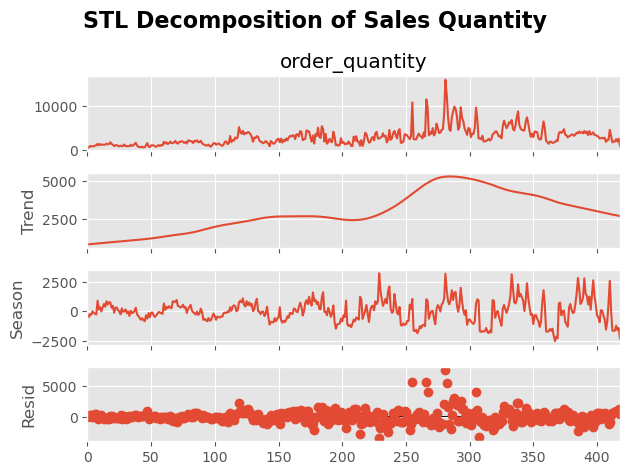

In [186]:
# STL Decomposition to Assess Components of Series...
stl_decomposition(sales['order_quantity'], series_name='Sales Quantity', period=52)

Based on the STL decomposition, there is a weak seasonal component. Based on this, I will try a seasonal ARIMA model as well as the nonseasonal ARIMA model below. Residual variance is also higher from weeks 250-300. I might be able to model this with an exogenous variable, as the heightened demand is a lagged result of the COVID pandemic (lagged because demand responded when inventory arrived). 

In [187]:
# Define Results DF
model_results = {
    'Model': [], 
    'MSE' : [],
    'RMSE' : [],
    'AIC' : [],
    'BIC' : [], 
    'Heteroskedasticity P-Val': [], 
    'Ljung-Box Residual Autocorrelation P-Val' : []
}

In [188]:
def model_fit_plot(df, date_col, actual_col, fit_col, residuals, title):
    # Diagnostic Plots... Actual vs Fitted, Residuals, ACF/PACF of Residuals, Histogram of Residuals
    import scipy.stats as stats
    plt.style.use('ggplot')
    fig, ax = plt.subplots(3,2, figsize=(15,10))
    fig.suptitle(f'Diagnostic Plots: {title}', fontsize=16, fontweight='bold')
    # Actual vs Fitted
    ax[0,0].plot(df[date_col], df[actual_col], label='Actual', color='blue')
    ax[0,0].plot(df[date_col], df[fit_col], label='Fitted', color='orange')
    ax[0,0].set_title('Actual vs Fitted Values', fontweight='bold')
    ax[0,0].set_xlabel('Date')
    ax[0,0].set_ylabel('Sales Quantity')
    ax[0,0].legend()
    ax[0,0].grid(True, alpha=0.3)
    # Residuals
    ax[0,1].plot(df[date_col], residuals, label='Residuals', color='red')
    ax[0,1].set_title('Residuals Over Time', fontweight='bold')
    ax[0,1].set_xlabel('Date')
    ax[0,1].set_ylabel('Residual Value')
    ax[0,1].legend()
    ax[0,1].grid(True, alpha=0.3)
    # ACF of Residuals
    plot_acf(residuals, lags=min(60, len(residuals)//2), ax=ax[1, 0], alpha=0.05)
    ax[1, 0].set_title('ACF of Residuals', fontweight='bold')
    # PACF of Residuals
    plot_pacf(residuals, lags=min(60, len(residuals)//2), ax=ax[1, 1], alpha=0.05, method='ywm')
    ax[1, 1].set_title('PACF of Residuals', fontweight='bold')
    # QQ plot of residuals
    sm.qqplot(residuals, line='s', ax=ax[2, 0])
    ax[2, 0].set_title('QQ Plot of Residuals', fontweight='bold')
    # Histogram of Residuals
    ax[2, 1].hist(residuals, bins=30, density=True, alpha=0.7, color='red', edgecolor='black')
    mean = np.mean(residuals)
    sigma = np.std(residuals)
    x = np.linspace(mean - 4*sigma, mean + 4*sigma, 1000)
    normal_pdf = stats.norm.pdf(x, mean, sigma)
    ax[2, 1].plot(x, normal_pdf, color='blue', linestyle='--', label='Normal PDF')
    ax[2, 1].legend()
    ax[2, 1].set_title('Histogram of Residuals', fontweight='bold')
    ax[2, 1].set_xlabel('Residual Value')
    ax[2, 1].set_ylabel('Density')
    ax[2, 1].grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def model_eval(fit_model):
    # MSE
    residuals = fit_model.resid
    mse = np.mean(residuals**2)
    # RMSE
    rmse = np.sqrt(mse)
    # AIC and BIC
    aic = fit_model.aic
    bic = fit_model.bic
    # Ljung Box Test on Residuals
    ljung_box_results = acorr_ljungbox(residuals, lags=1, return_df=True)
    ljung_box_pval = ljung_box_results['lb_pvalue'].iloc[0]
    # Heteroskedasticity Test on Residuals
    from statsmodels.stats.diagnostic import het_arch
    arch_test = het_arch(residuals, nlags=12)
    arch_pval = arch_test[1]
    return mse, rmse, aic, bic, ljung_box_pval, arch_pval

/home/eca4zm/miniforge3/envs/tseries2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:         order_quantity   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3107.263
Date:                Wed, 18 Feb 2026   AIC                           6224.525
Time:                        21:42:43   BIC                           6243.997
Sample:                             0   HQIC                          6232.265
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9058      0.176      5.136      0.000       0.560       1.251
ar.L2         -0.4813      0.094     -5.142      0.000      -0.665      -0.298
ma.L1         -1.2347      0.179     -6.898      0.0

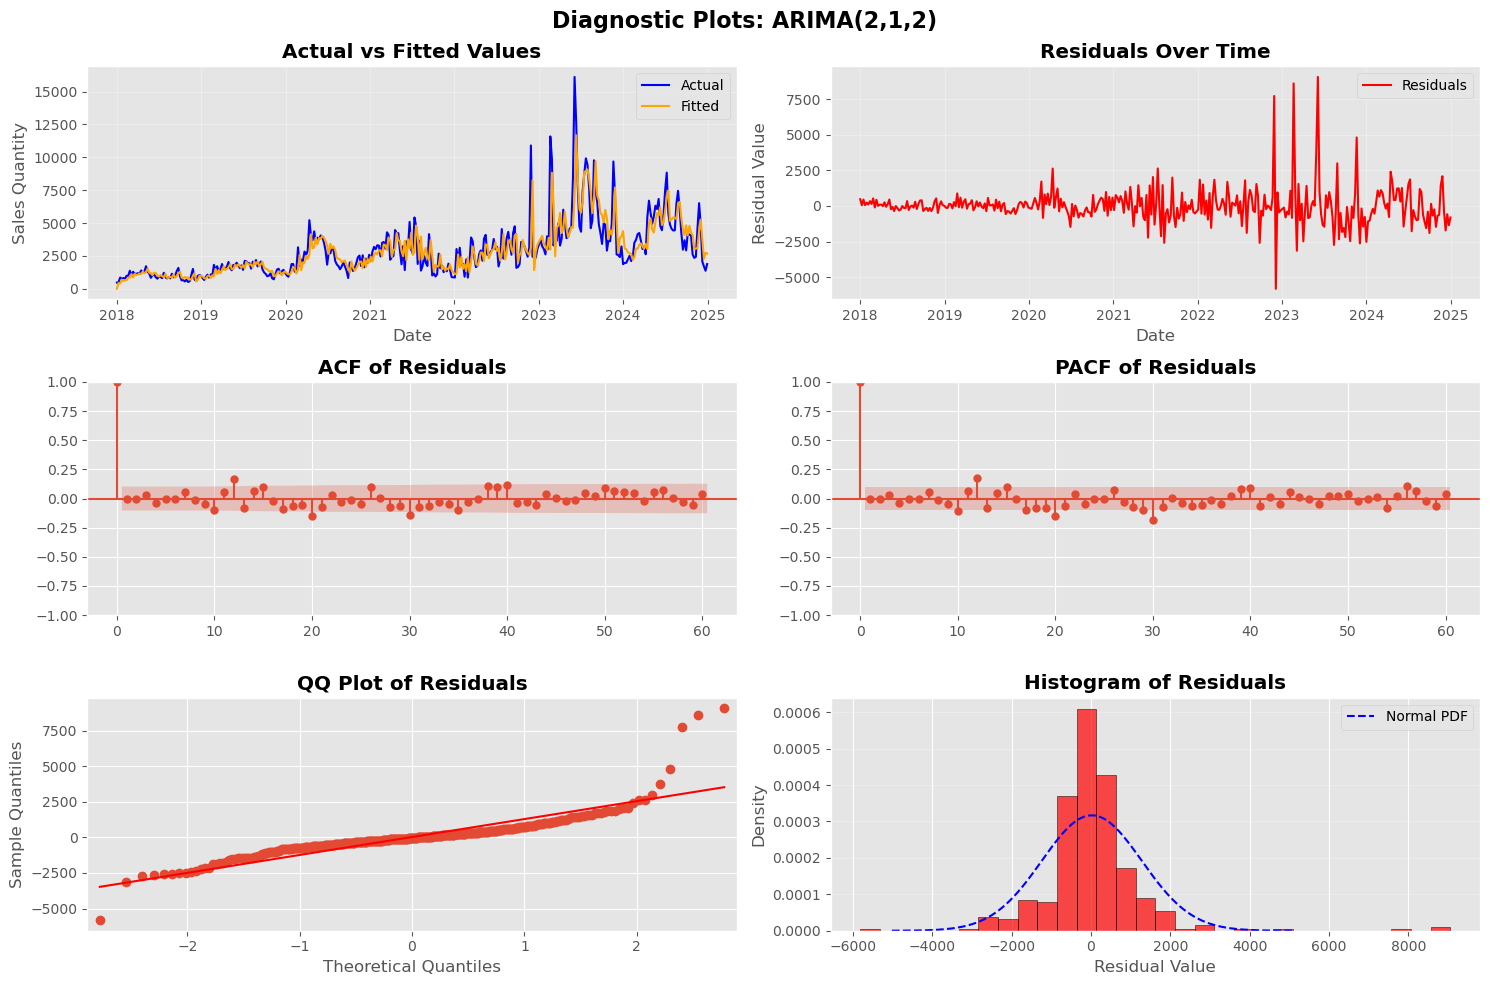

In [189]:
# Fit 212 Model
P = 2
D = 1
Q = 2
Y = train['order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q))
model_212 = model.fit()
print(model_212.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'ARIMA_{P,D,Q}'
train[FIT_COL] = model_212.fittedvalues
residuals = model_212.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'ARIMA({P},{D},{Q})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_212)
model_results['Model'].append(f'ARIMA({P},{D},{Q})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)

Overall, this model fit well aside from the heteroskedasticity that I see above in the residuals plot. The ACF and PACF of the residuals show no spikes, however, which is a good sign. The histogram shows that the residuals are approximately normally distributed (slightly tighter than normal), which is also a good sign. Finally, the QQ plot shows that the residuals are approximately normally distributed as well; however, there is some deviation from normality in the right tail, which is a sign that this model is not perfect.

                               SARIMAX Results                                
Dep. Variable:         order_quantity   No. Observations:                  364
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3109.994
Date:                Wed, 18 Feb 2026   AIC                           6227.988
Time:                        21:42:44   BIC                           6243.565
Sample:                             0   HQIC                          6234.180
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4966      0.048     10.274      0.000       0.402       0.591
ar.L2         -0.2506      0.042     -5.909      0.000      -0.334      -0.167
ma.L1         -0.8013      0.045    -17.674      0.0

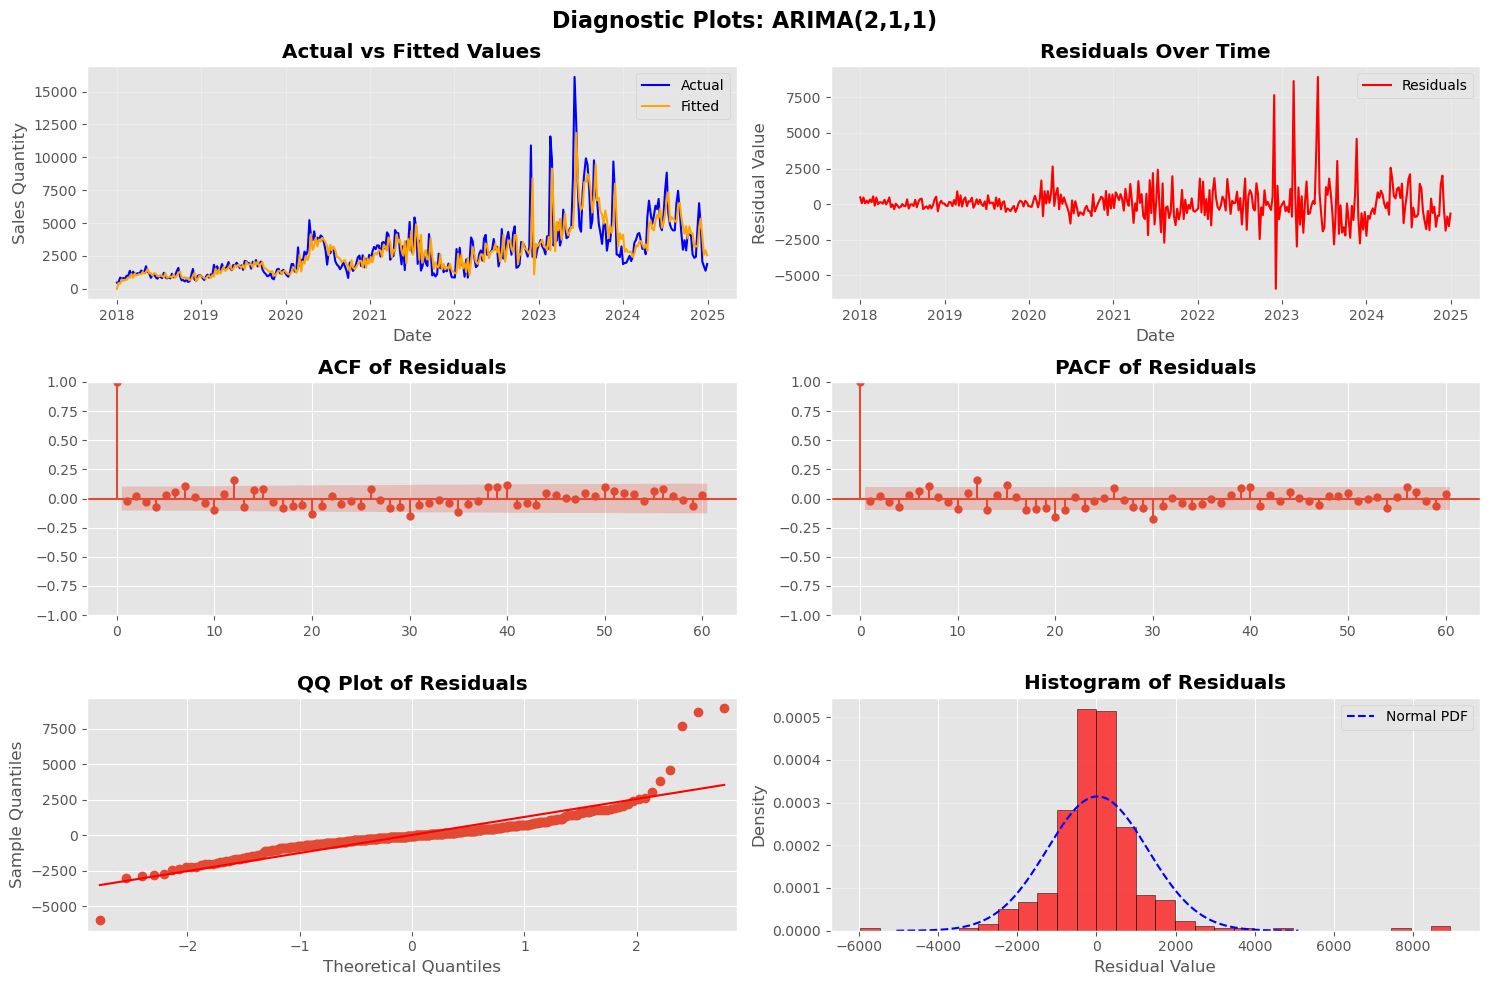

In [190]:
# 211 Model
P = 2
D = 1
Q = 1
Y = train['order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q))
model_211 = model.fit()
print(model_211.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'ARIMA_{P,D,Q}'
train[FIT_COL] = model_211.fittedvalues
residuals = model_211.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'ARIMA({P},{D},{Q})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_211)
model_results['Model'].append(f'ARIMA({P},{D},{Q})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)

Similar results to the ARIMA(2,1,2) model, but slightly better BIC. There appears to be heteroskedasticity in the residuals, which is a problem. The QQ plot alos has some deviation from normality in the right tail, which is another sign that this model is not perfect. 

Based on the heteroskedasticity, I am going to log transform the data and refit the model to see if that helps... 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=258.011, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=308.463, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=290.317, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=266.249, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=306.502, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=244.324, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=242.653, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=241.898, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=242.975, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=241.455, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=236.657, Time=0.50 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=237.763, Time=0.51 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=237.867, Time=0.51 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=240.169, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=238.3

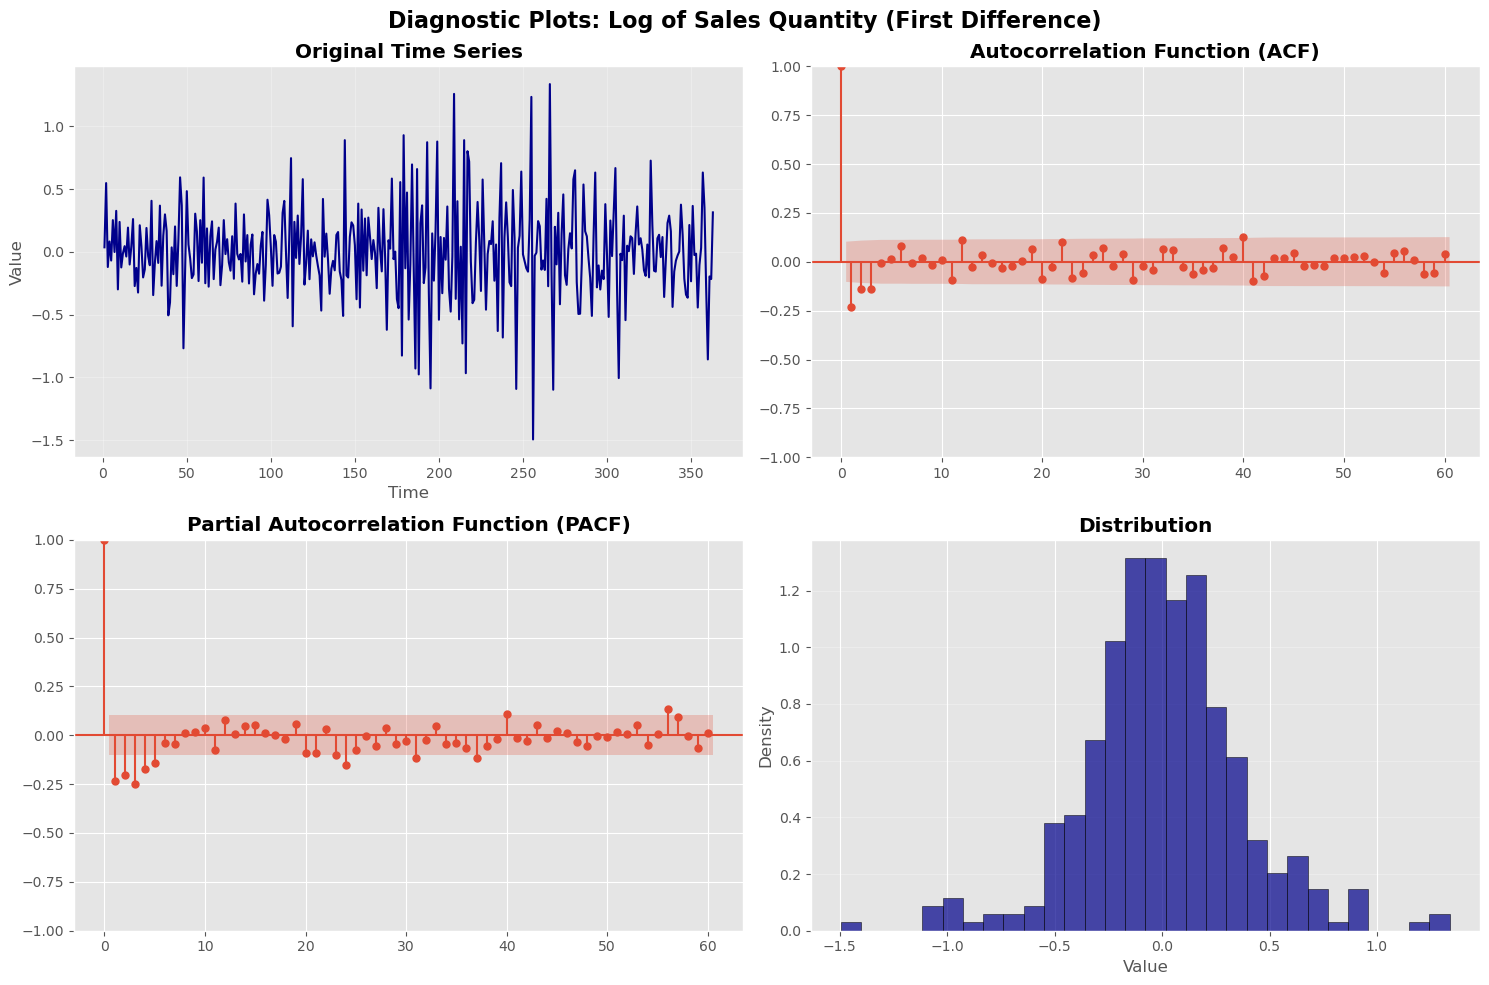

In [191]:
# Log Transform Data and Refit Model
auto_arima_model_log = pm.auto_arima(
    train['log_order_quantity'],
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)
print(auto_arima_model_log.summary())
diagnostic_plot(train['log_order_quantity'].diff().dropna(), title='Log of Sales Quantity (First Difference)')

Based on the autoarima above, the best model to try after a log transform is a ARIMA(1,1,4). In the data that I first differenced above, I believe the best model to try would be ARIMA(3,1,1) due to the significant ACF spikes at lag 1, which suggests MA(1) would work well, and significant spikes at PACF lag 1-3 suggest that AR(3) would work well (spikes at lag 4-5 are boarderline...). I will try both, and also SARIMA.

                               SARIMAX Results                                
Dep. Variable:     log_order_quantity   No. Observations:                  364
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -111.422
Date:                Wed, 18 Feb 2026   AIC                            234.845
Time:                        21:42:54   BIC                            258.211
Sample:                             0   HQIC                           244.133
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7348      0.128      5.753      0.000       0.484       0.985
ma.L1         -1.1612      0.134     -8.635      0.000      -1.425      -0.898
ma.L2          0.0802      0.091      0.881      0.3

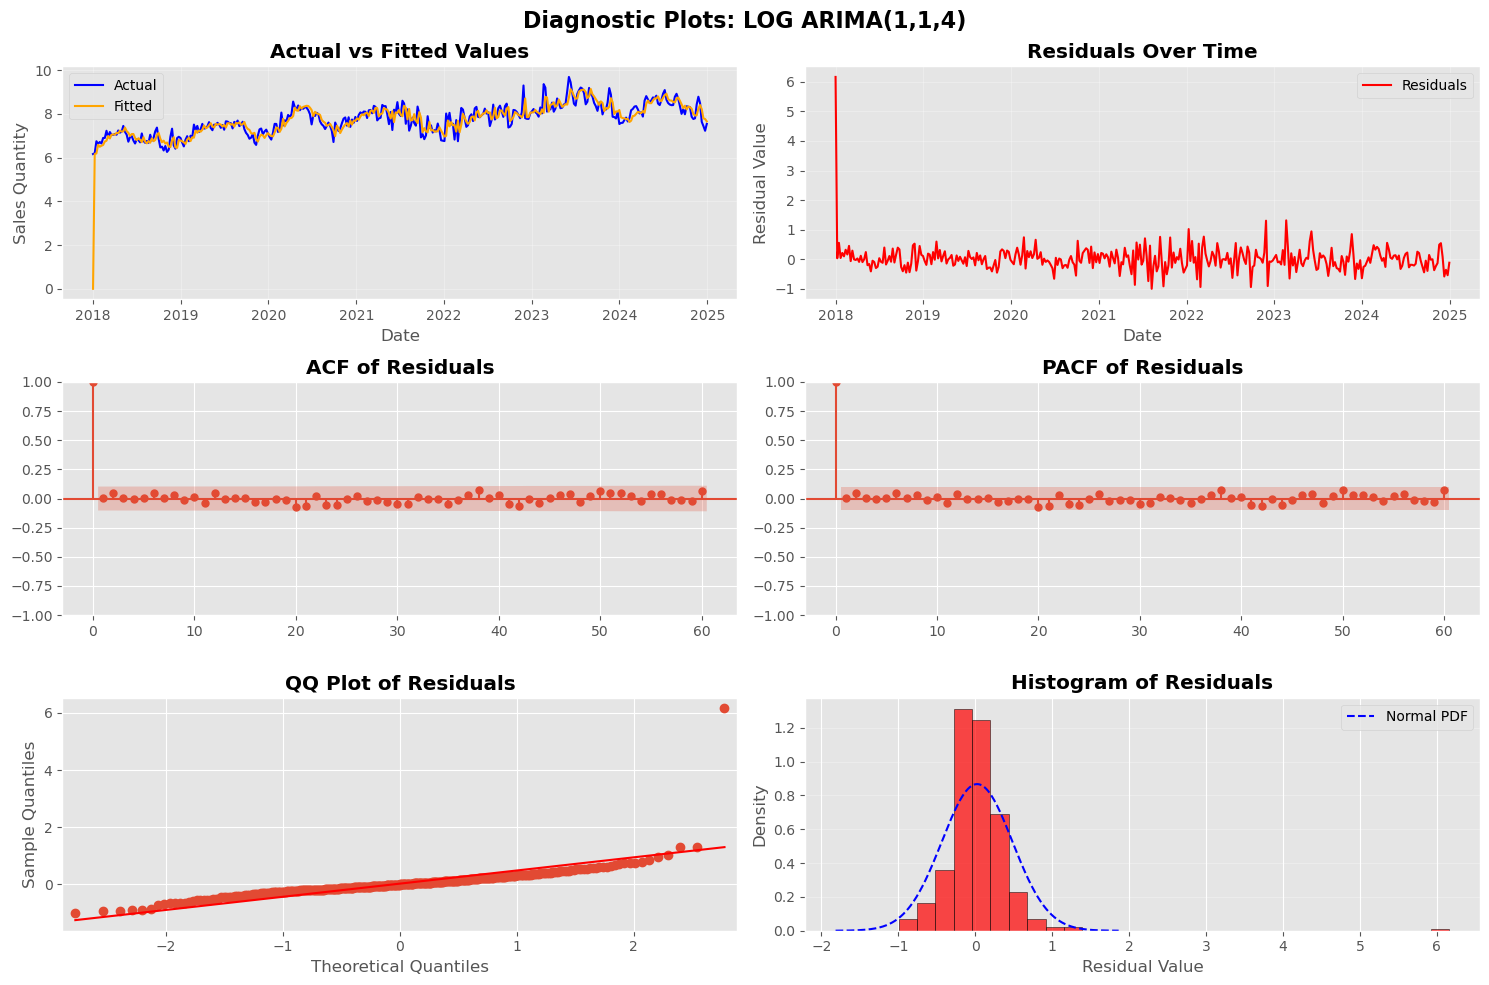

In [192]:
# Fit Model
P = 1
D = 1
Q = 4
Y = train['log_order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q))
model_log_114 = model.fit()
print(model_log_114.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'LOG_ARIMA_{P,D,Q}'
train[FIT_COL] = model_log_114.fittedvalues
residuals = model_log_114.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='log_order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'LOG ARIMA({P},{D},{Q})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_log_114)
model_results['Model'].append(f'LOG ARIMA({P},{D},{Q})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)

                               SARIMAX Results                                
Dep. Variable:     log_order_quantity   No. Observations:                  364
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -113.080
Date:                Wed, 18 Feb 2026   AIC                            236.160
Time:                        21:42:55   BIC                            255.632
Sample:                             0   HQIC                           243.900
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2239      0.115      1.949      0.051      -0.001       0.449
ar.L2         -0.1277      0.054     -2.366      0.018      -0.233      -0.022
ar.L3         -0.1557      0.072     -2.175      0.0

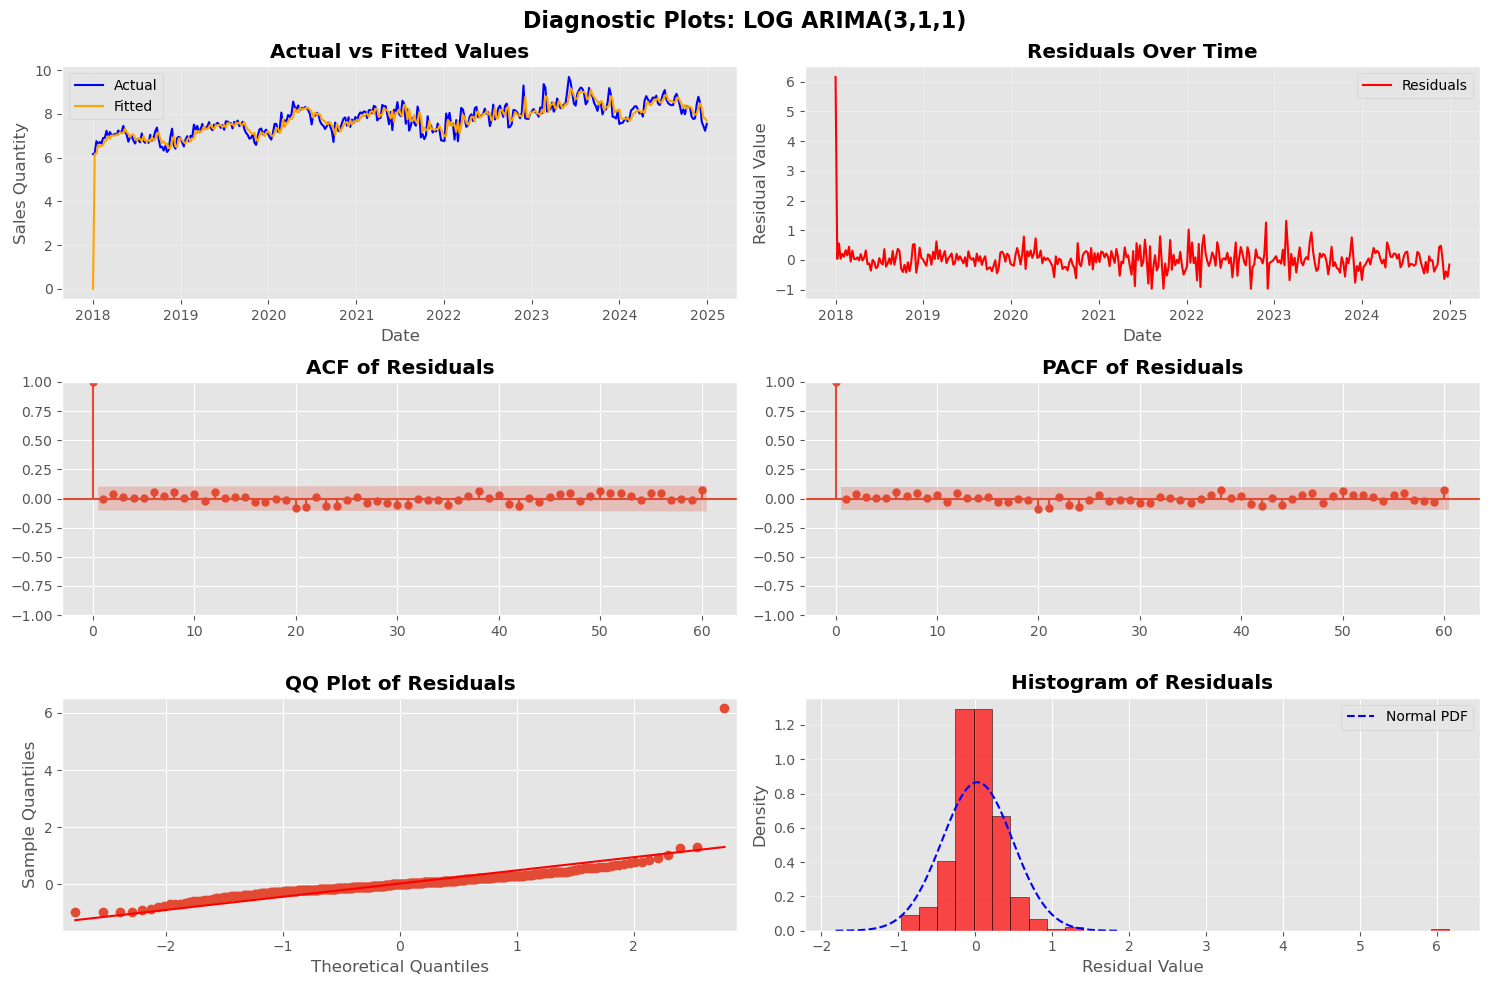

In [193]:
# Fit Model
P = 3
D = 1
Q = 1
Y = train['log_order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q))
model_log_311 = model.fit()
print(model_log_311.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'LOG_ARIMA_{P,D,Q}'
train[FIT_COL] = model_log_311.fittedvalues
residuals = model_log_311.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='log_order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'LOG ARIMA({P},{D},{Q})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_log_311)
model_results['Model'].append(f'LOG ARIMA({P},{D},{Q})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)

The log transform helped dramatically to reduce the heteroskedasticity and outliers in the residuals in both models above. In both models, the ACF and PACF of the residuals show no spikes and appear to be white noise, which is a good sign. The histograms are also normally distributed, and the QQ plot shows that the residuals are approximately normally distributed as well. Overall, this model fit is better than the non-log transformed model, so I will move forward with this version. 

I am unsure why the prediction is 0 at T=0. 

                                     SARIMAX Results                                      
Dep. Variable:                 log_order_quantity   No. Observations:                  364
Model:             ARIMA(1, 1, 4)x(1, 0, [1], 52)   Log Likelihood                -110.147
Date:                            Wed, 18 Feb 2026   AIC                            236.294
Time:                                    21:43:06   BIC                            267.449
Sample:                                         0   HQIC                           248.678
                                            - 364                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6940      0.150      4.612      0.000       0.399       0.989
ma.L1         -1.1346      0.154   

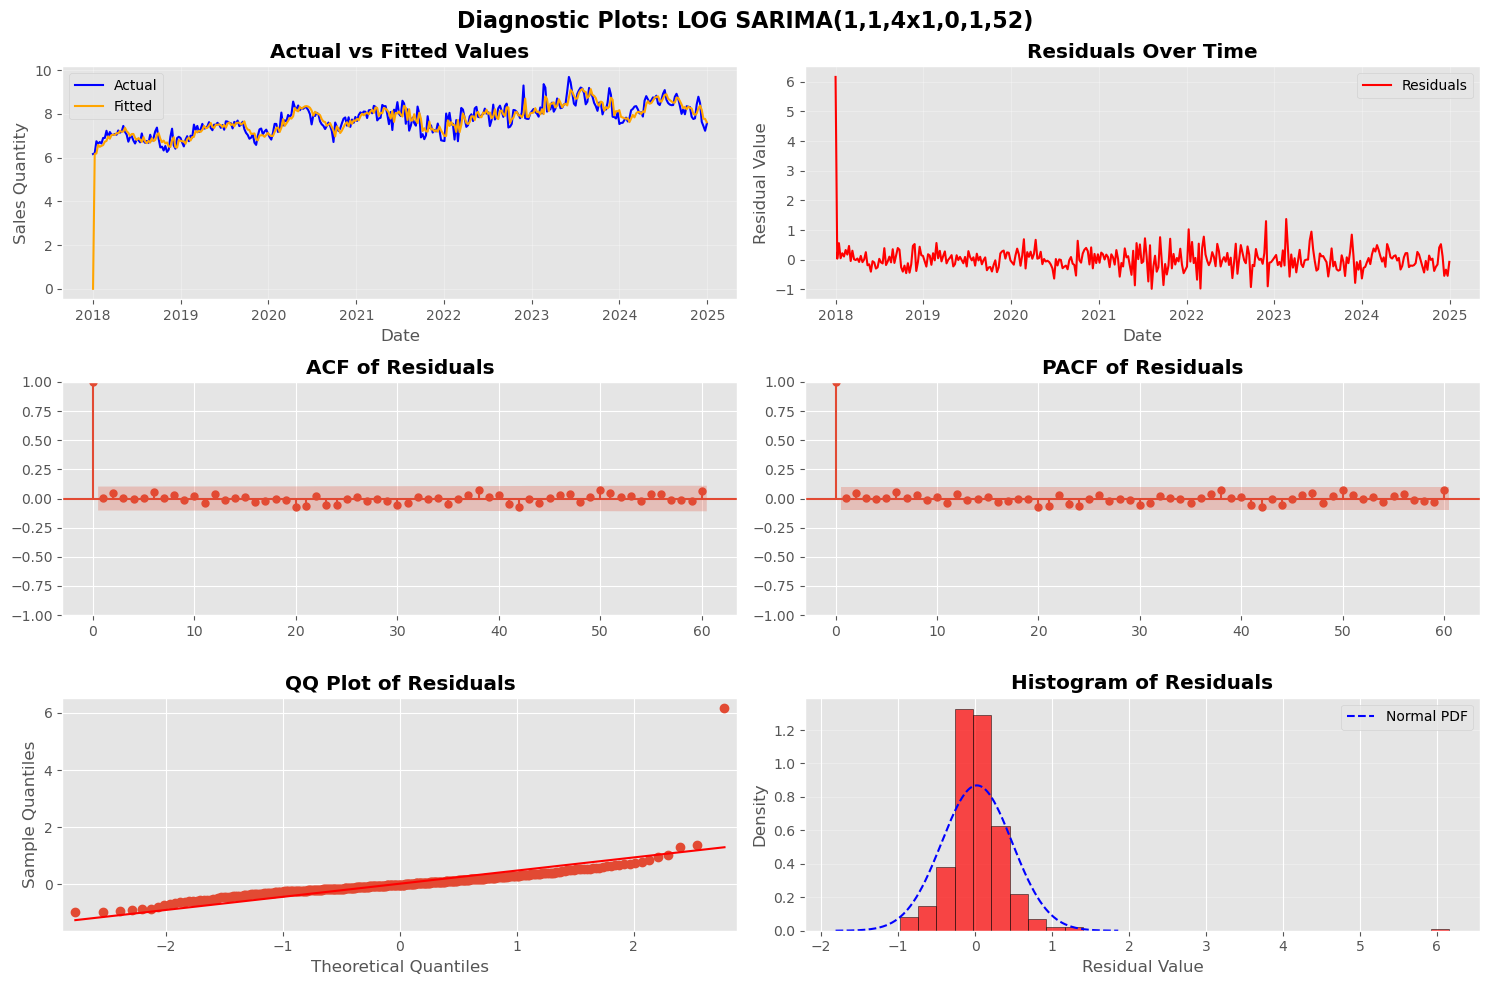

In [194]:
# SARIMA LOG MODEL
P = 1
D = 1
Q = 4
P_S = 1 
D_S = 0
Q_S = 1
SEASON = 52
Y = train['log_order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q), seasonal_order=(P_S, D_S, Q_S, SEASON))
model_log_114101 = model.fit()
print(model_log_114101.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'LOG_SARIMA_{P,D,Q}x{P_S,D_S,Q_S,SEASON}'
train[FIT_COL] = model_log_114101.fittedvalues
residuals = model_log_114101.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='log_order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'LOG SARIMA({P},{D},{Q}x{P_S},{D_S},{Q_S},{SEASON})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_log_114101)
model_results['Model'].append(f'LOG SARIMA({P},{D},{Q}x{P_S},{D_S},{Q_S},{SEASON})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)


                                    SARIMAX Results                                     
Dep. Variable:               log_order_quantity   No. Observations:                  364
Model:             ARIMA(3, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -111.085
Date:                          Wed, 18 Feb 2026   AIC                            236.170
Time:                                  21:43:15   BIC                            263.430
Sample:                                       0   HQIC                           247.006
                                          - 364                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2235      0.105      2.137      0.033       0.018       0.429
ar.L2         -0.1246      0.054     -2.314      0.

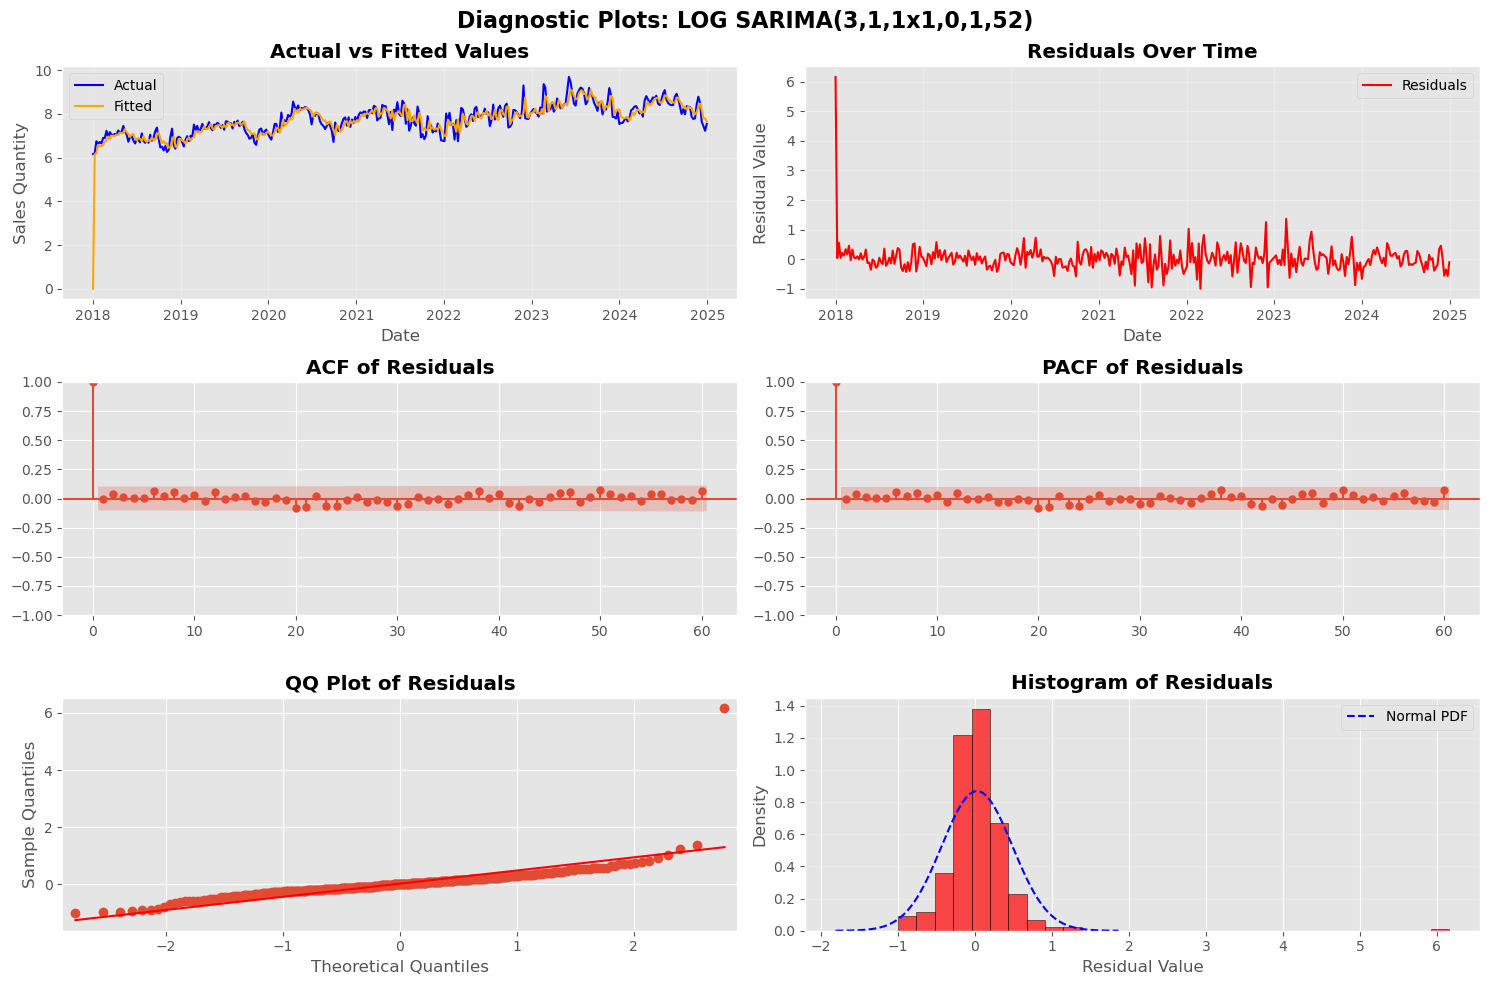

In [195]:
# SARIMA LOG MODEL
P = 3
D = 1
Q = 1
P_S = 1
D_S = 0
Q_S = 1
SEASON = 52
Y = train['log_order_quantity']

# Fit Model and Output Summary
model = ARIMA(Y, order=(P,D,Q), seasonal_order=(P_S, D_S, Q_S, SEASON))
model_log_311101 = model.fit()
print(model_log_311101.summary())

# Add fitted values to sales df for diagnostics
FIT_COL = f'LOG_SARIMA_{P,D,Q}x{P_S,D_S,Q_S,SEASON}'
train[FIT_COL] = model_log_311101.fittedvalues
residuals = model_log_311101.resid

# Model Diagnostic Results
model_fit_plot(train, date_col='date', actual_col='log_order_quantity', fit_col=FIT_COL, residuals=residuals, title=f'LOG SARIMA({P},{D},{Q}x{P_S},{D_S},{Q_S},{SEASON})')
mse, rmse, aic, bic, ljung_box_pval, arch_pval = model_eval(model_log_311101)
model_results['Model'].append(f'LOG SARIMA({P},{D},{Q}x{P_S},{D_S},{Q_S},{SEASON})')
model_results['MSE'].append(mse)
model_results['RMSE'].append(rmse)
model_results['AIC'].append(aic)
model_results['BIC'].append(bic)
model_results['Ljung-Box Residual Autocorrelation P-Val'].append(ljung_box_pval)
model_results['Heteroskedasticity P-Val'].append(arch_pval)


In [196]:
# Model Results
model_results_df = pd.DataFrame(model_results)
model_results_df.style.format("{:,.4f}", subset=['MSE', 'RMSE', 'AIC', 'BIC', 'Ljung-Box Residual Autocorrelation P-Val', 'Heteroskedasticity P-Val'])

,Model,MSE,RMSE,AIC,BIC,Heteroskedasticity P-Val,Ljung-Box Residual Autocorrelation P-Val
0,"ARIMA(2,1,2)","1,587,354.6262","1,259.9026","6,224.5252","6,243.9972",0.0012,0.9230
1,"ARIMA(2,1,1)","1,612,083.4325","1,269.6785","6,227.9875","6,243.5651",0.0005,0.6947
2,"LOG ARIMA(1,1,4)",0.2121,0.4605,234.8447,258.2112,0.0001,0.9186
3,"LOG ARIMA(3,1,1)",0.2131,0.4617,236.1601,255.6321,0.0000,0.9820
4,"LOG SARIMA(1,1,4x1,0,1,52)",0.2113,0.4597,236.2939,267.4492,0.0001,0.9153
5,"LOG SARIMA(3,1,1x1,0,1,52)",0.2118,0.4602,236.1696,263.4304,0.0000,0.9787


In all cases, the heteroskedasticity P Value is very low, which suggests that there is still some heteroskedasticity in the residuals. This may be due to the odd spike at T=0, of which I am unsure of the cause...

Otherwise, the SARIMA model appears to have the best fit in terms of AIC, MSE, and RMSE. In all cases, the Ljung Box test fails to reject the null hypothesis, which suggests that there is NO autocorrelation in the residuals (they are just white noise). 

I will transform the predictions back to the orginal scale and plot them against the actuals to see how each tracks the data. 

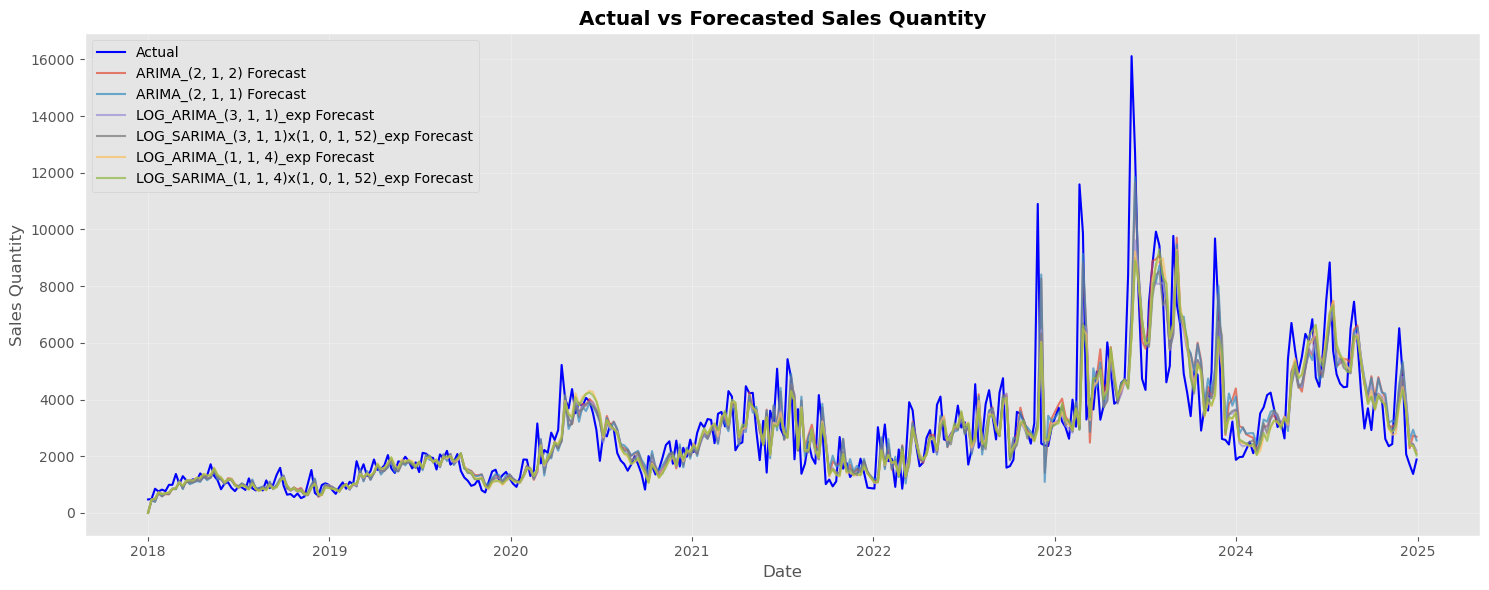

In [197]:
# Plotting Predictions vs Actual for Each Model on the Training Data
cols = ['LOG_ARIMA_(3, 1, 1)', 'LOG_SARIMA_(3, 1, 1)x(1, 0, 1, 52)', 'LOG_ARIMA_(1, 1, 4)', 'LOG_SARIMA_(1, 1, 4)x(1, 0, 1, 52)']
for col in cols:
    train[col + '_exp'] = np.exp(train[col])
final_cols = ['ARIMA_(2, 1, 2)', 'ARIMA_(2, 1, 1)'] + [c + '_exp' for c in cols]

plt.style.use('ggplot')
plt.figure(figsize=(15,6))
sns.lineplot(x='date', y='order_quantity', data=train, label='Actual', color='blue')
for col in final_cols:
    sns.lineplot(x='date', y=col, data=train, label=col + ' Forecast', alpha=0.7)
plt.title('Actual vs Forecasted Sales Quantity', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

All of the models track the data well. We will see how they perform during prediction on the test set below...

### **PART D: FORECASTING**

Compare the performance of the forecasts of your selected models using the appropriate methods on a test data set. Show graphics of the forecast performance to include confidence intervals. Describe your results and conclusions about the usefulness of the models you evaluated to forecast in the application domain of the data set.

In [209]:
# Make Predictions
test = test[['date']]
weeks = test.shape[0]
fc = model_212.get_forecast(steps=weeks)
test['ARIMA_212_Forecast'] = fc.predicted_mean.values
test['ARIMA_212_Forecast_Lower'] = fc.conf_int().iloc[:,0]
test['ARIMA_212_Forecast_Upper'] = fc.conf_int().iloc[:,1]

fc = model_211.get_forecast(steps=weeks)
test['ARIMA_211_Forecast'] = fc.predicted_mean.values
test['ARIMA_211_Forecast_Lower'] = fc.conf_int().iloc[:,0]
test['ARIMA_211_Forecast_Upper'] = fc.conf_int().iloc[:,1]

fc = model_log_114.get_forecast(steps=weeks)
test['LOG_ARIMA_114_Forecast'] = np.exp(fc.predicted_mean.values)
test['LOG_ARIMA_114_Forecast_Lower'] = np.exp(fc.conf_int().iloc[:,0])
test['LOG_ARIMA_114_Forecast_Upper'] = np.exp(fc.conf_int().iloc[:,1])

fc = model_log_114101.get_forecast(steps=weeks)
test['LOG_SARIMA_114101_Forecast'] = np.exp(fc.predicted_mean.values)
test['LOG_SARIMA_114101_Forecast_Lower'] = np.exp(fc.conf_int().iloc[:,0])
test['LOG_SARIMA_114101_Forecast_Upper'] = np.exp(fc.conf_int().iloc[:,1])

fc = model_log_311.get_forecast(steps=weeks)
test['LOG_ARIMA_311_Forecast'] = np.exp(fc.predicted_mean.values)
test['LOG_ARIMA_311_Forecast_Lower'] = np.exp(fc.conf_int().iloc[:,0])
test['LOG_ARIMA_311_Forecast_Upper'] = np.exp(fc.conf_int().iloc[:,1])

fc = model_log_311101.get_forecast(steps=weeks)
test['LOG_SARIMA_311101_Forecast'] = np.exp(fc.predicted_mean.values)
test['LOG_SARIMA_311101_Forecast_Lower'] = np.exp(fc.conf_int().iloc[:,0])
test['LOG_SARIMA_311101_Forecast_Upper'] = np.exp(fc.conf_int().iloc[:,1])

In [210]:
final_data = pd.merge(sales[['date','order_quantity']], test, on='date', how='left')

In [212]:
def plot_forecast_with_ci(df, date_col, actual_col, forecast_col, lower_col, upper_col, title):
    '''Function to plot actual vs forecast with confidence intervals'''
    plt.style.use('ggplot')
    plt.figure(figsize=(15,6))
    sns.lineplot(x=date_col, y=actual_col, data=df, label='Actual', color='blue')
    sns.lineplot(x=date_col, y=forecast_col, data=df, label='ARIMA(3,1,3) Forecast', color='orange')
    plt.fill_between(df[date_col], df[lower_col], df[upper_col], color='orange', alpha=0.3, label='ARIMA(3,1,3) 95% CI')
    plt.title(title, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

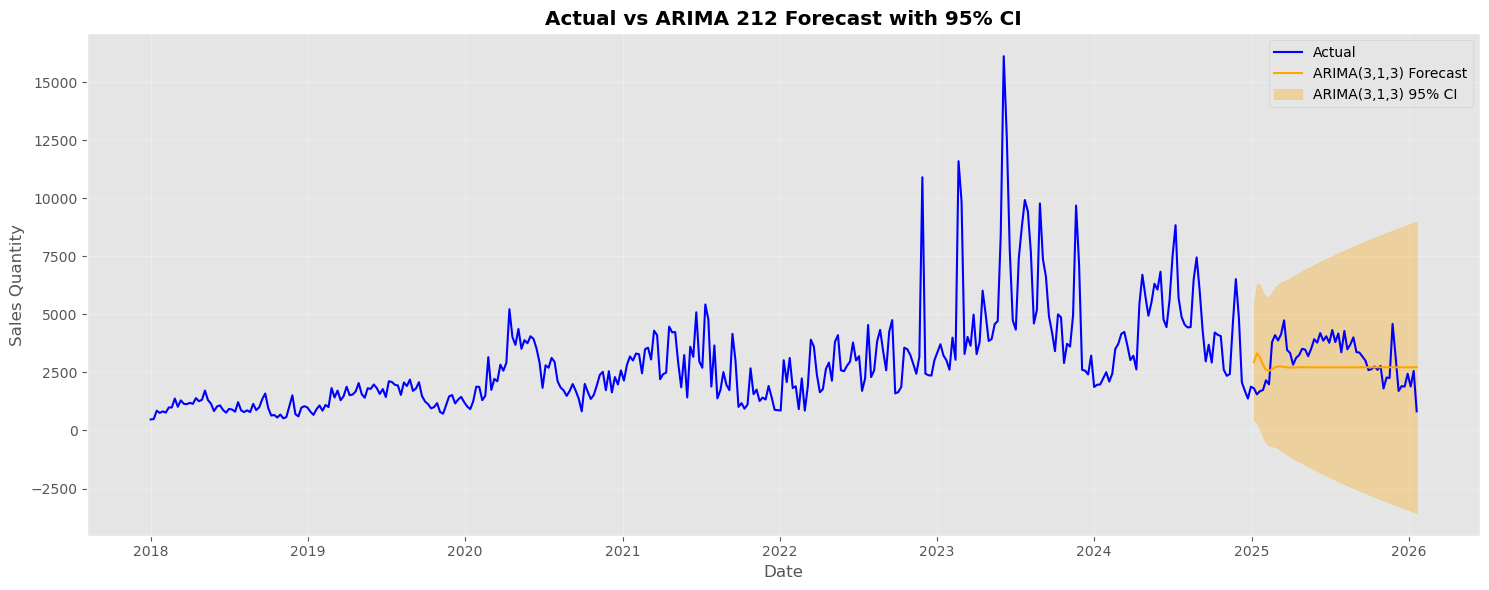

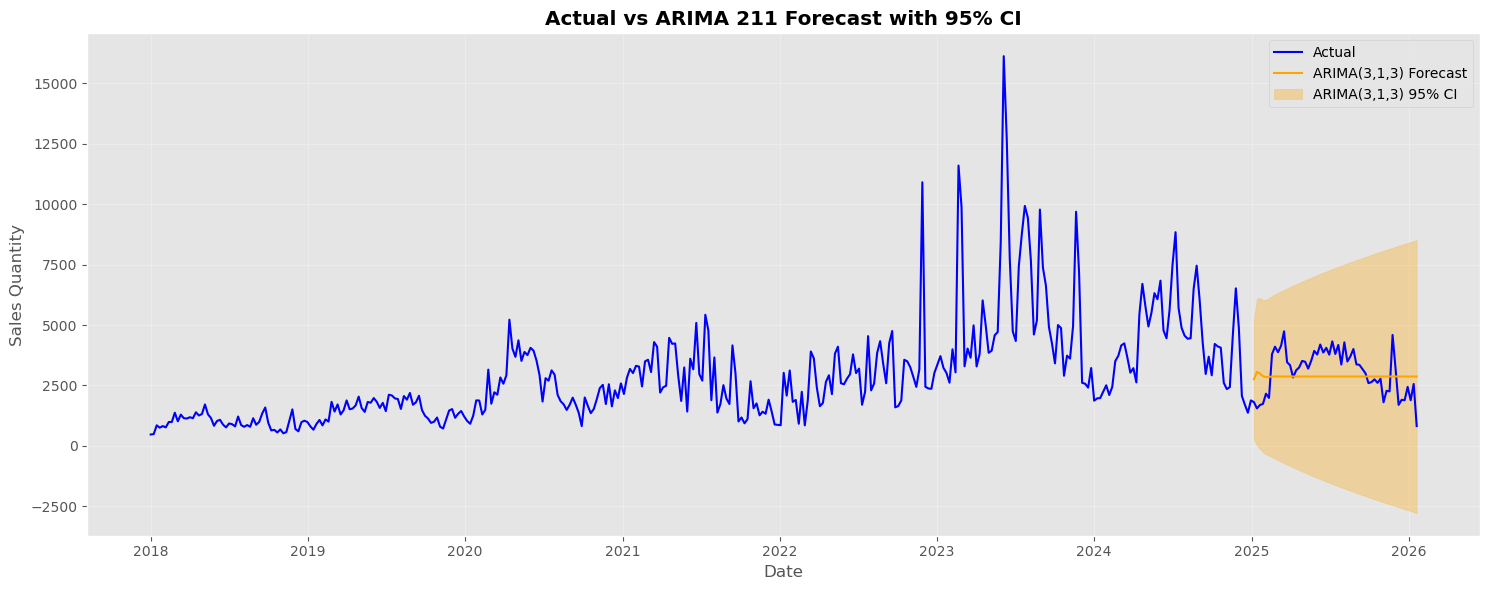

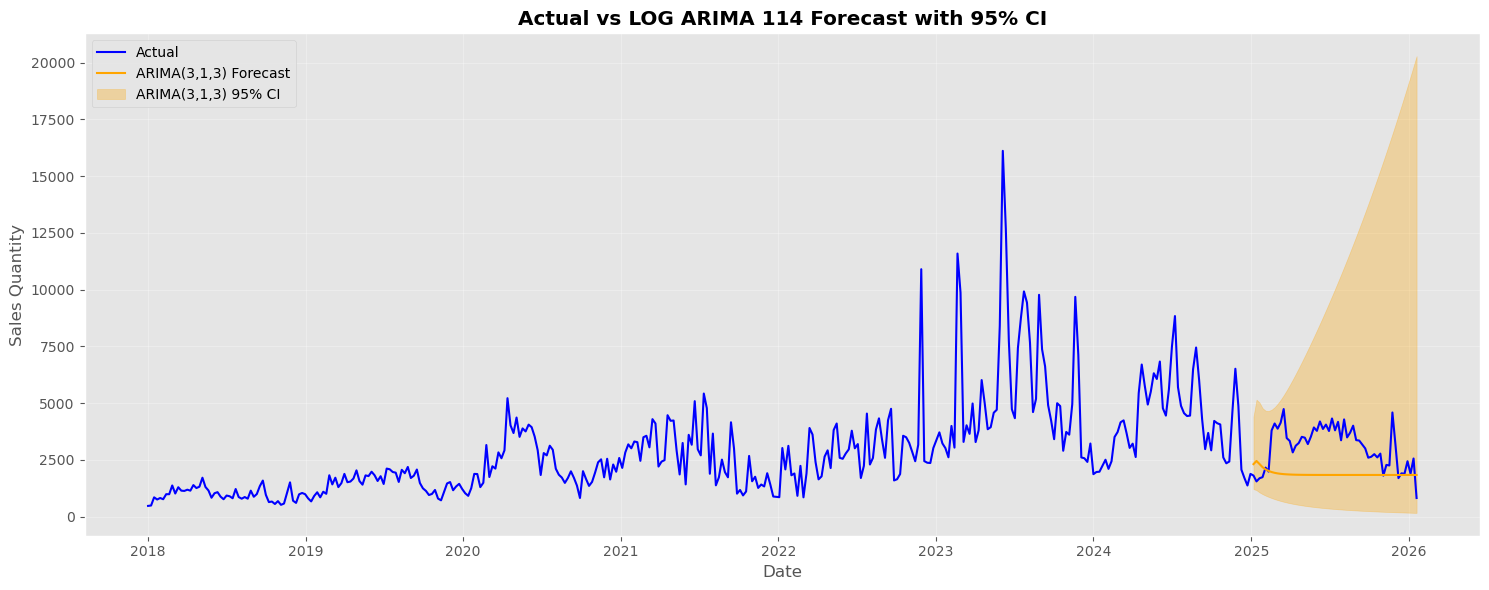

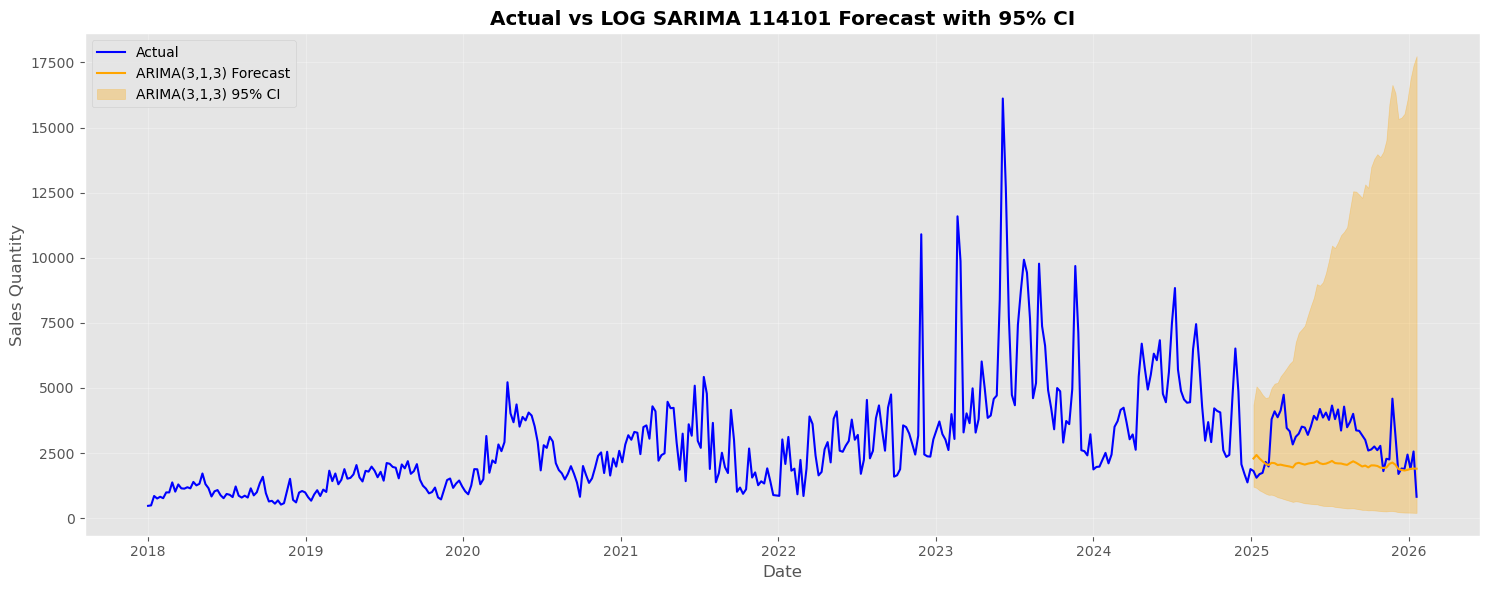

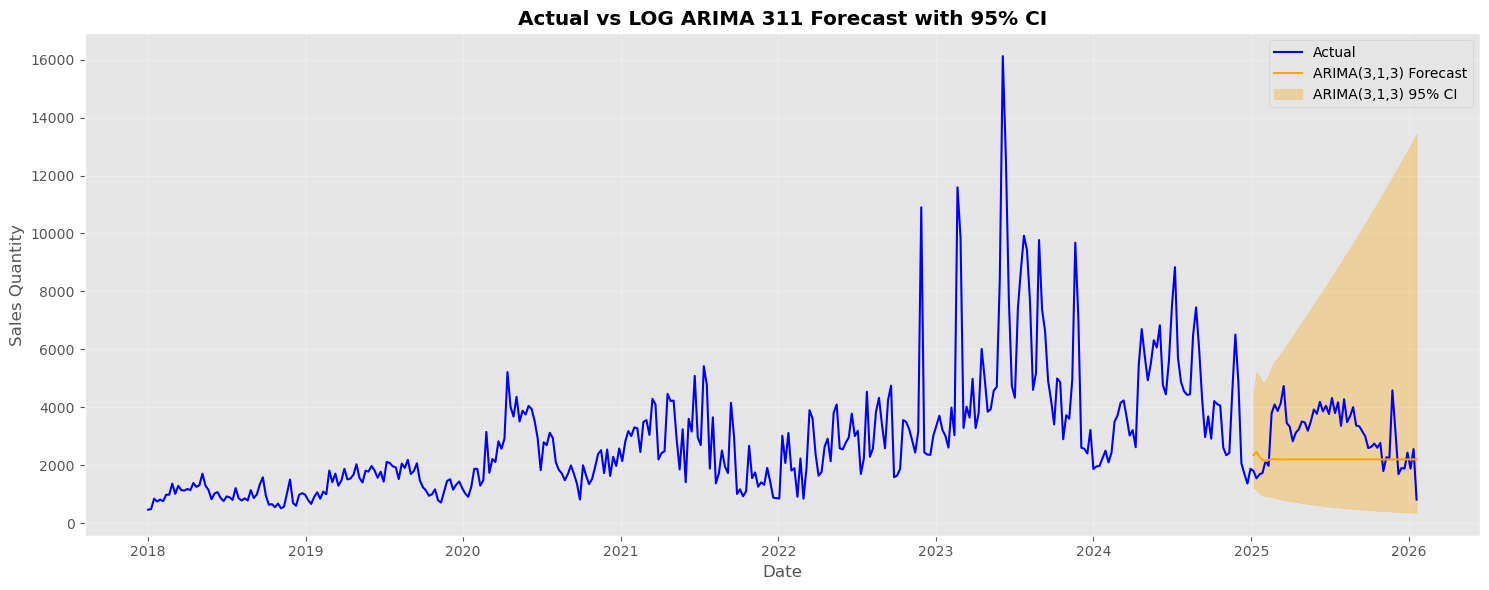

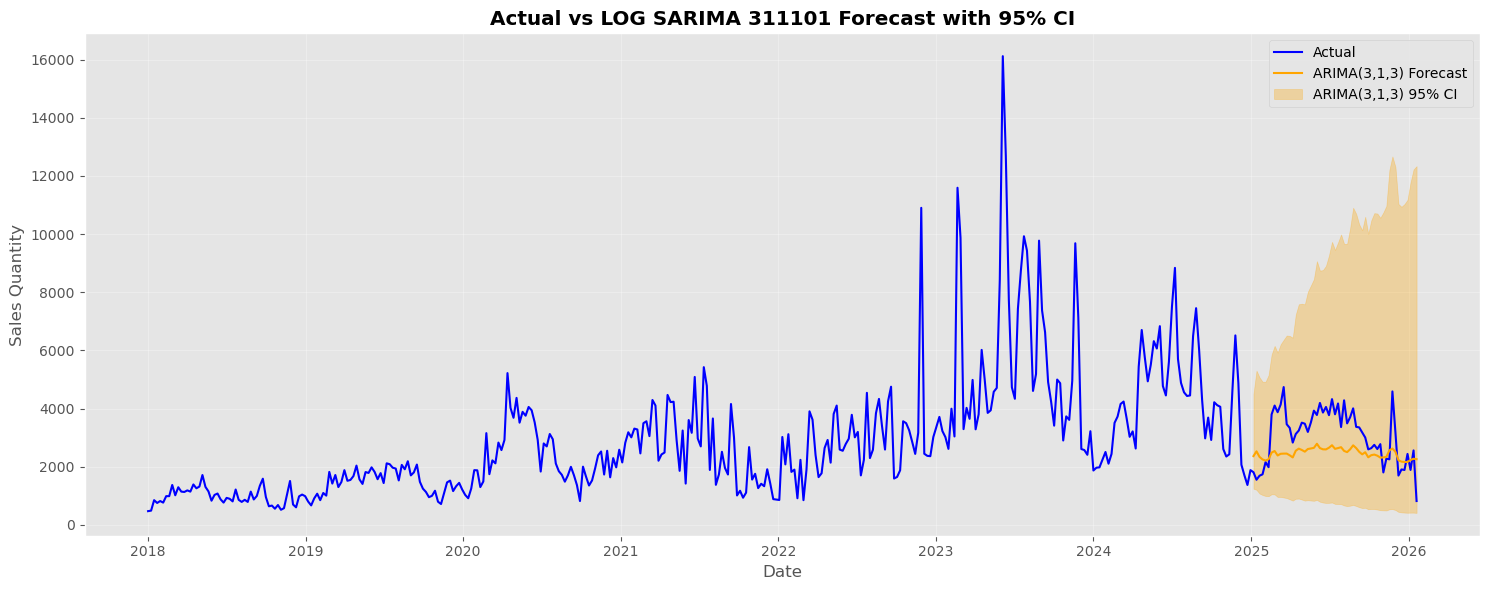

In [214]:
# Plot the Forecasts vs Actuals with Confidence Intervals
forcasts = ['ARIMA_212_Forecast', 'ARIMA_211_Forecast', 'LOG_ARIMA_114_Forecast', 'LOG_SARIMA_114101_Forecast', 'LOG_ARIMA_311_Forecast', 'LOG_SARIMA_311101_Forecast']
for forecast in forcasts:
    lower_col = forecast.replace('Forecast', 'Forecast_Lower')
    upper_col = forecast.replace('Forecast', 'Forecast_Upper')
    plot_forecast_with_ci(
        final_data, 
        date_col='date', 
        actual_col='order_quantity', 
        forecast_col=forecast, 
        lower_col=lower_col, 
        upper_col=upper_col, 
        title=f'Actual vs {forecast.replace("_", " ")} with 95% CI'
    )

Based on these diagnostic plots, the SARIMA(3,1,1)x(1,0,1,52) model performed the best. The forecasts track the seasonal pattern well, and much closer to the actuals than the other models. It even captures the slight uptick in demand towards the end of the calendar year. 

In [216]:
# Now look at Residuals and Diagnostics for Each Model
final_data['ARIMA_212_Residuals'] = final_data['order_quantity'] - final_data['ARIMA_212_Forecast']
final_data['ARIMA_211_Residuals'] = final_data['order_quantity'] - final_data['ARIMA_211_Forecast']
final_data['LOG_ARIMA_114_Residuals'] = final_data['order_quantity'] - final_data['LOG_ARIMA_114_Forecast']
final_data['LOG_ARIMA_311_Residuals'] = final_data['order_quantity'] - final_data['LOG_ARIMA_311_Forecast']
final_data['LOG_SARIMA_114101_Residuals'] = final_data['order_quantity'] - final_data['LOG_SARIMA_114101_Forecast']
final_data['LOG_SARIMA_311101_Residuals'] = final_data['order_quantity'] - final_data['LOG_SARIMA_311101_Forecast']

mse_212 = np.mean(final_data['ARIMA_212_Residuals']**2)
mse_211 = np.mean(final_data['ARIMA_211_Residuals']**2)
mse_log_114 = np.mean(final_data['LOG_ARIMA_114_Residuals']**2)
mse_log_311 = np.mean(final_data['LOG_ARIMA_311_Residuals']**2)
mse_log_sarima_311101 = np.mean(final_data['LOG_SARIMA_311101_Residuals']**2)
mse_log_sarima_114101 = np.mean(final_data['LOG_SARIMA_114101_Residuals']**2)

rmse_212 = np.sqrt(mse_212)
rmse_211 = np.sqrt(mse_211)
rmse_log_114 = np.sqrt(mse_log_114)
rmse_log_311 = np.sqrt(mse_log_311)
rmse_log_sarima_311101 = np.sqrt(mse_log_sarima_311101)
rmse_log_sarima_114101 = np.sqrt(mse_log_sarima_114101)

results_df = pd.DataFrame({
    'Model': ['ARIMA(2,1,2)', 'ARIMA(2,1,1)', 'LOG ARIMA(1,1,4)', 'LOG ARIMA(3,1,1)', 'LOG SARIMA(1,1,4)x(0,0,0,52)', 'LOG SARIMA(3,1,1)x(0,0,0,52)'],
    'MSE': [mse_212, mse_211, mse_log_114, mse_log_311, mse_log_sarima_114101, mse_log_sarima_311101],
    'RMSE': [rmse_212, rmse_211, rmse_log_114, rmse_log_311, rmse_log_sarima_114101, rmse_log_sarima_311101]
})
results_df.style.format({"MSE": "{:,.2f}", "RMSE": "{:,.2f}"}).background_gradient(subset=['MSE', 'RMSE'], cmap='Blues')

,Model,MSE,RMSE
0,"ARIMA(2,1,2)","1,019,003.89","1,009.46"
1,"ARIMA(2,1,1)","883,801.79",940.11
2,"LOG ARIMA(1,1,4)","2,375,647.02","1,541.31"
3,"LOG ARIMA(3,1,1)","1,606,709.98","1,267.56"
4,"LOG SARIMA(1,1,4)x(0,0,0,52)","1,836,718.13","1,355.26"
5,"LOG SARIMA(3,1,1)x(0,0,0,52)","1,016,749.05","1,008.34"


The simple ARIMA(2,1,1) model actual has the lowest error; however, it does not capture the seasonality at all. The SARIMA(3,1,1)x(1,0,1,52) model has the second lowest error, and it captures the seasonality well. 

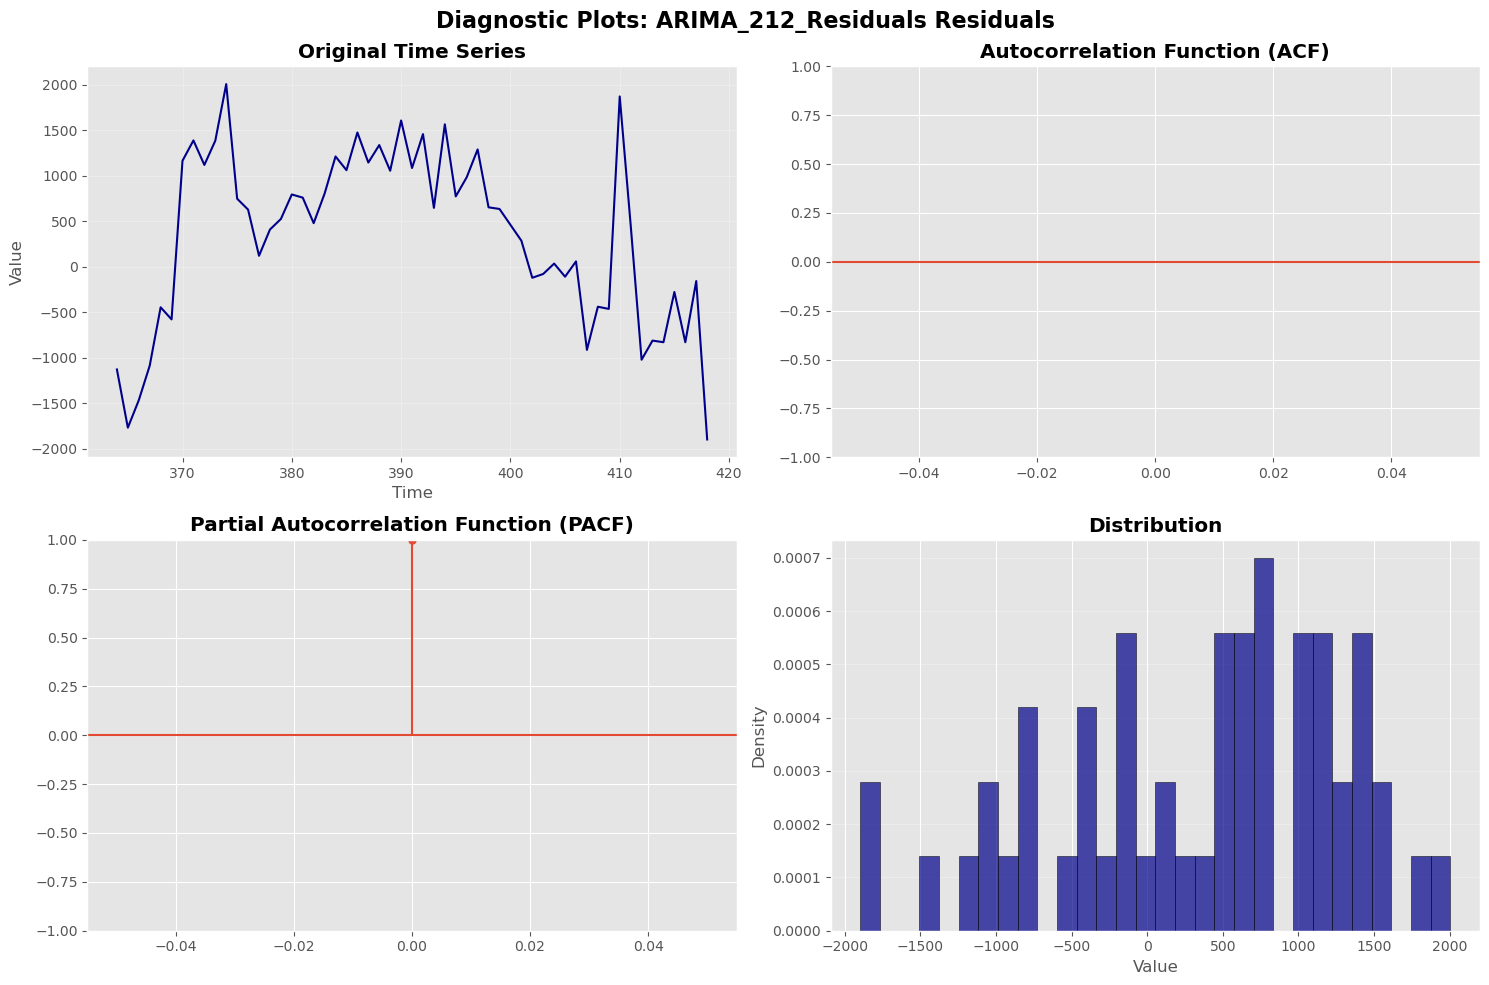

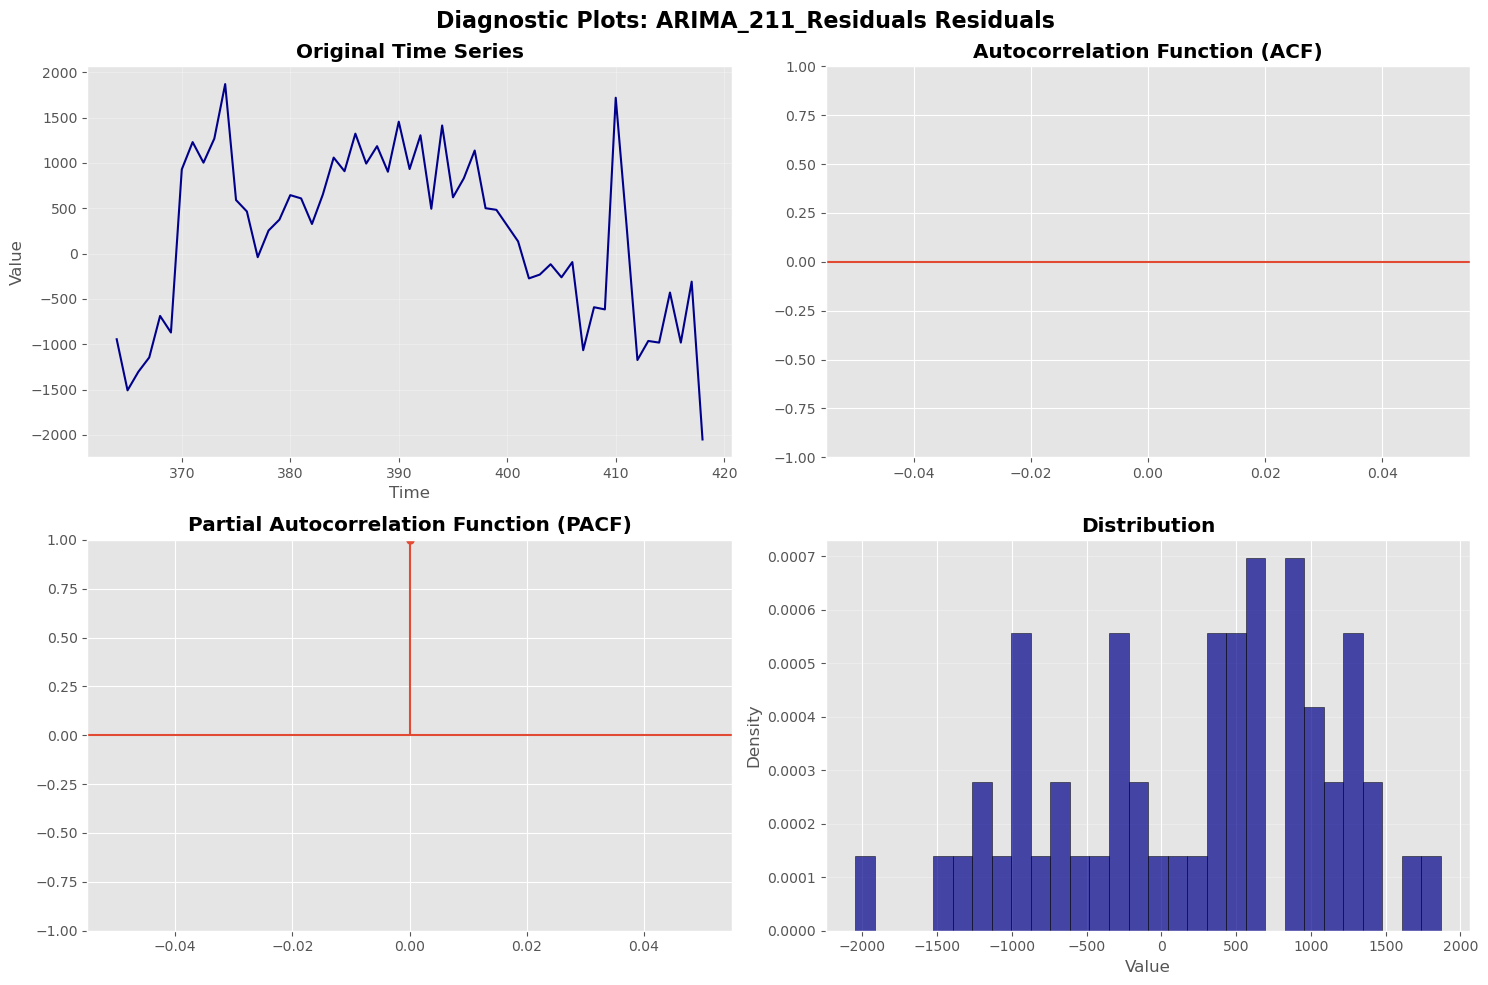

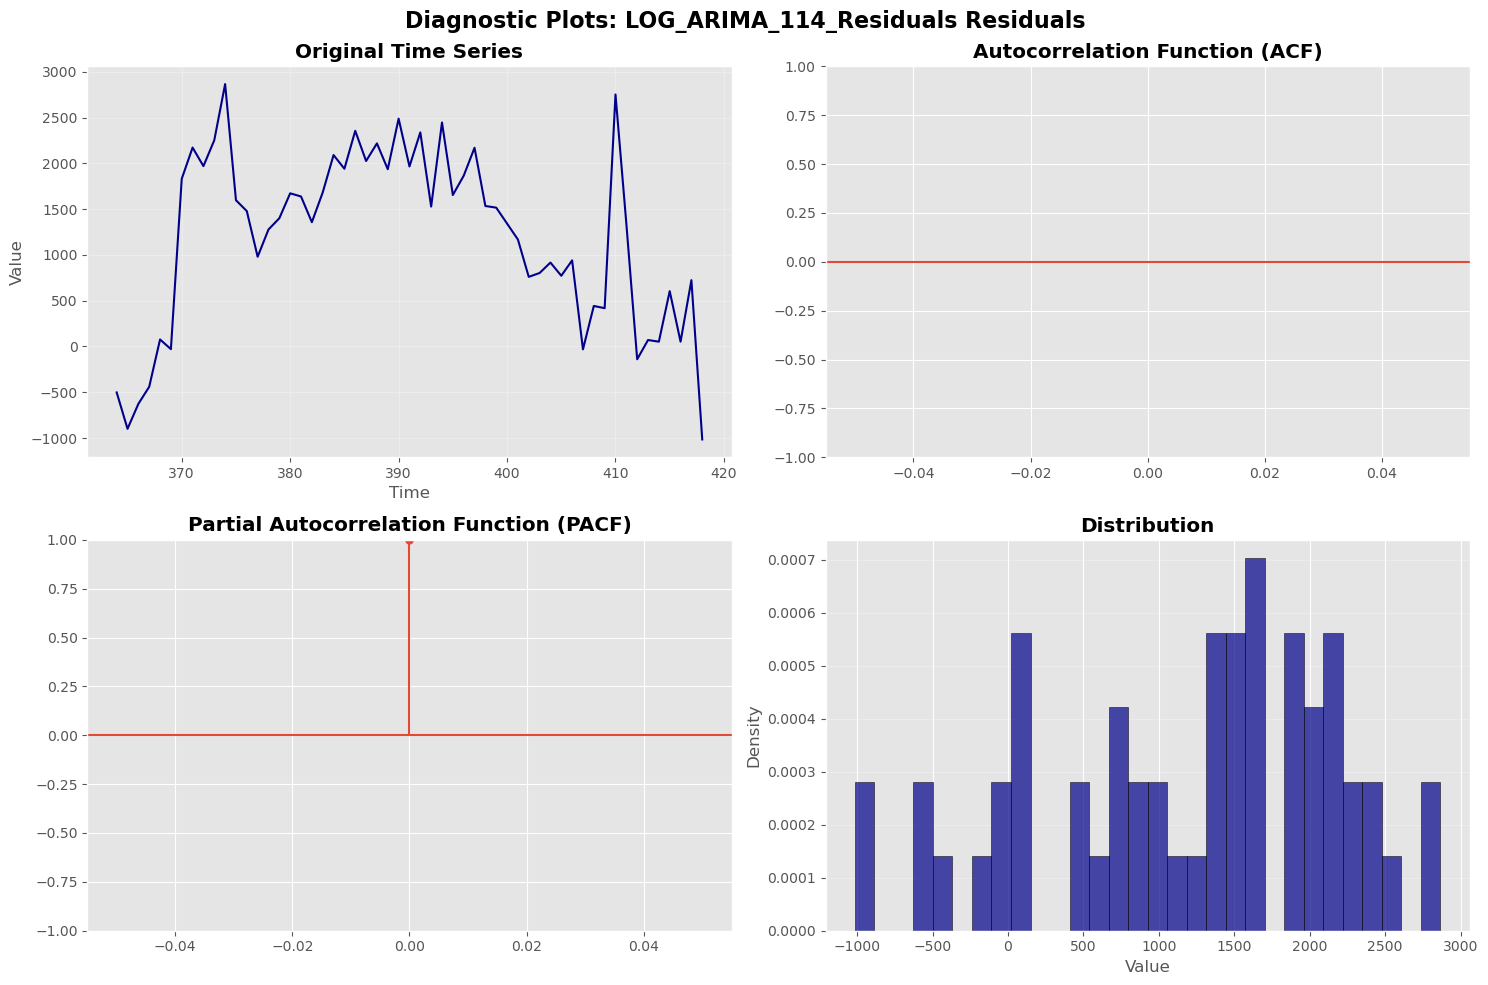

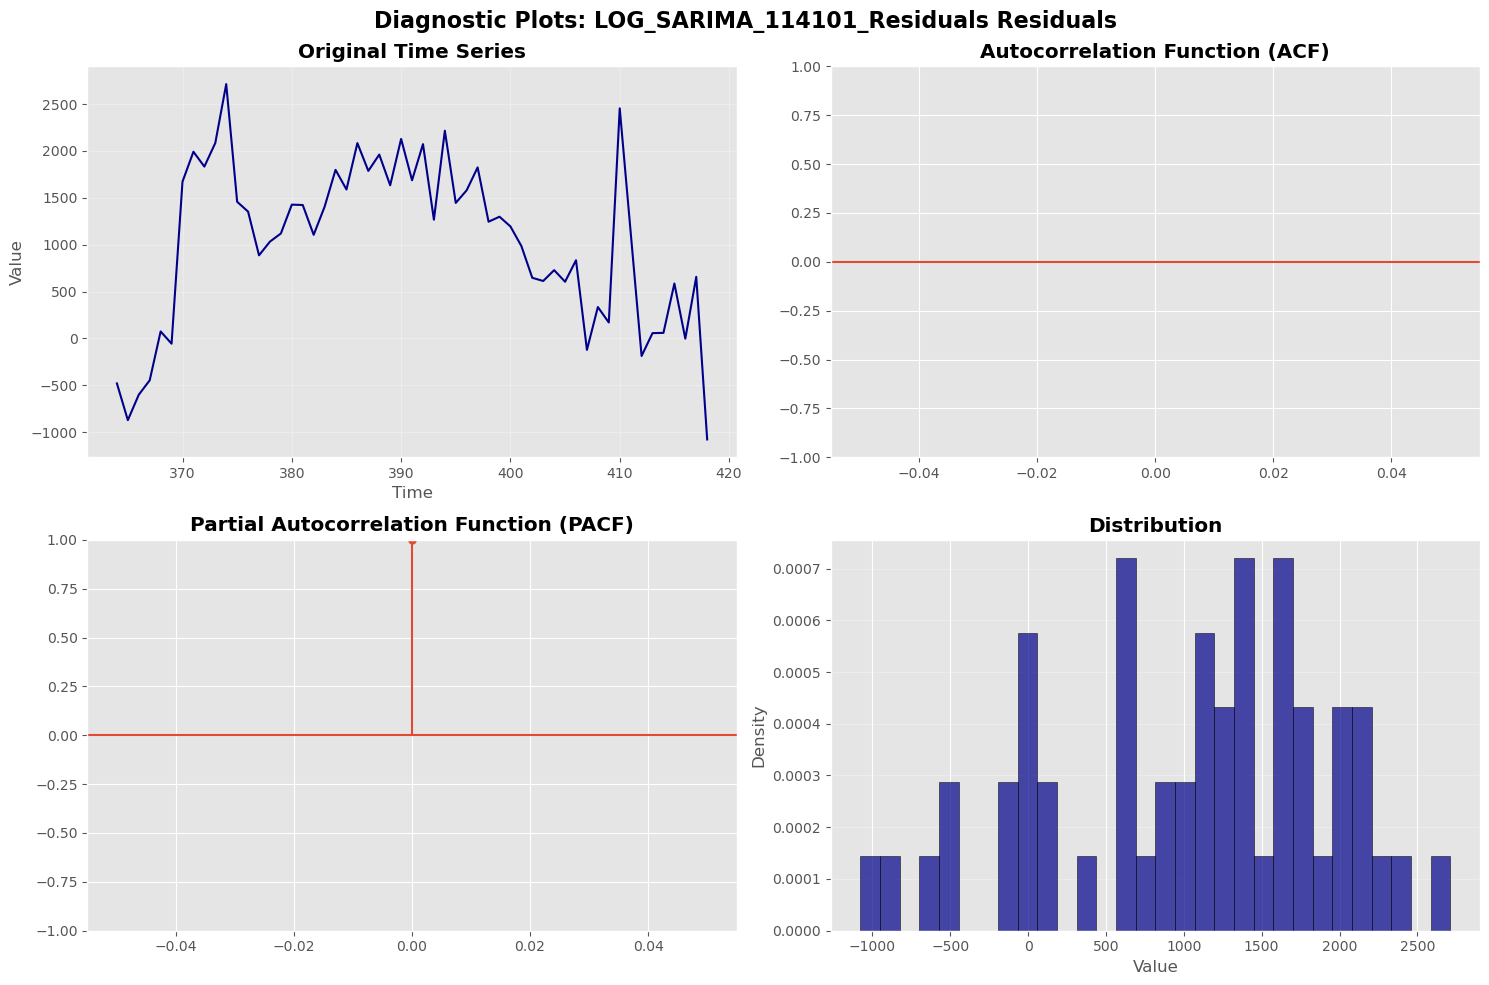

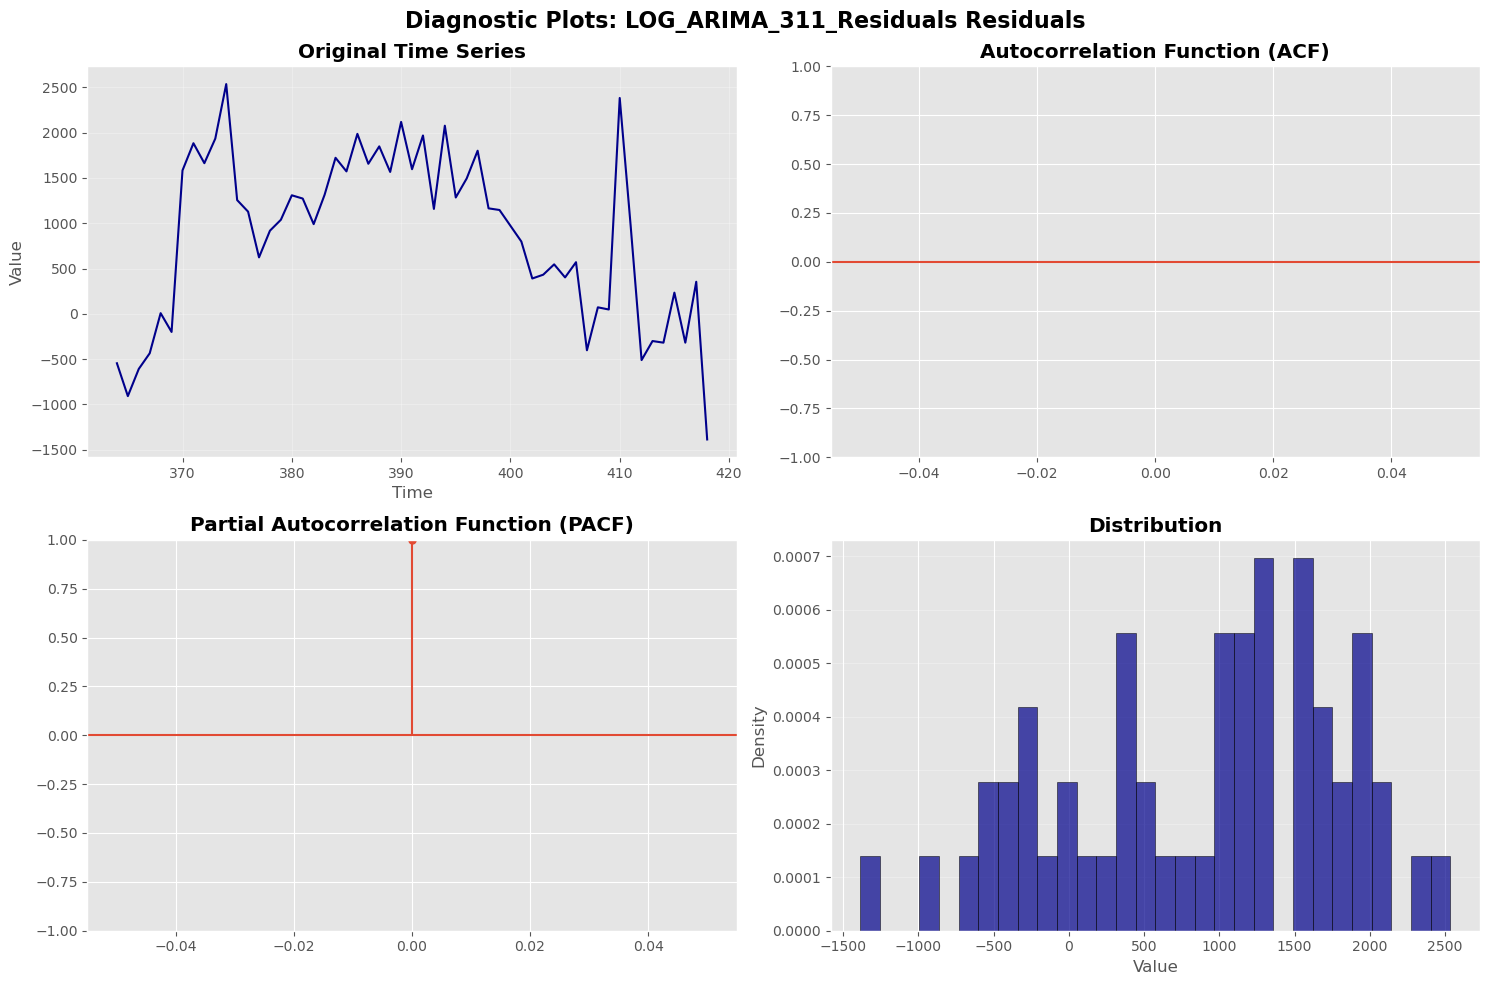

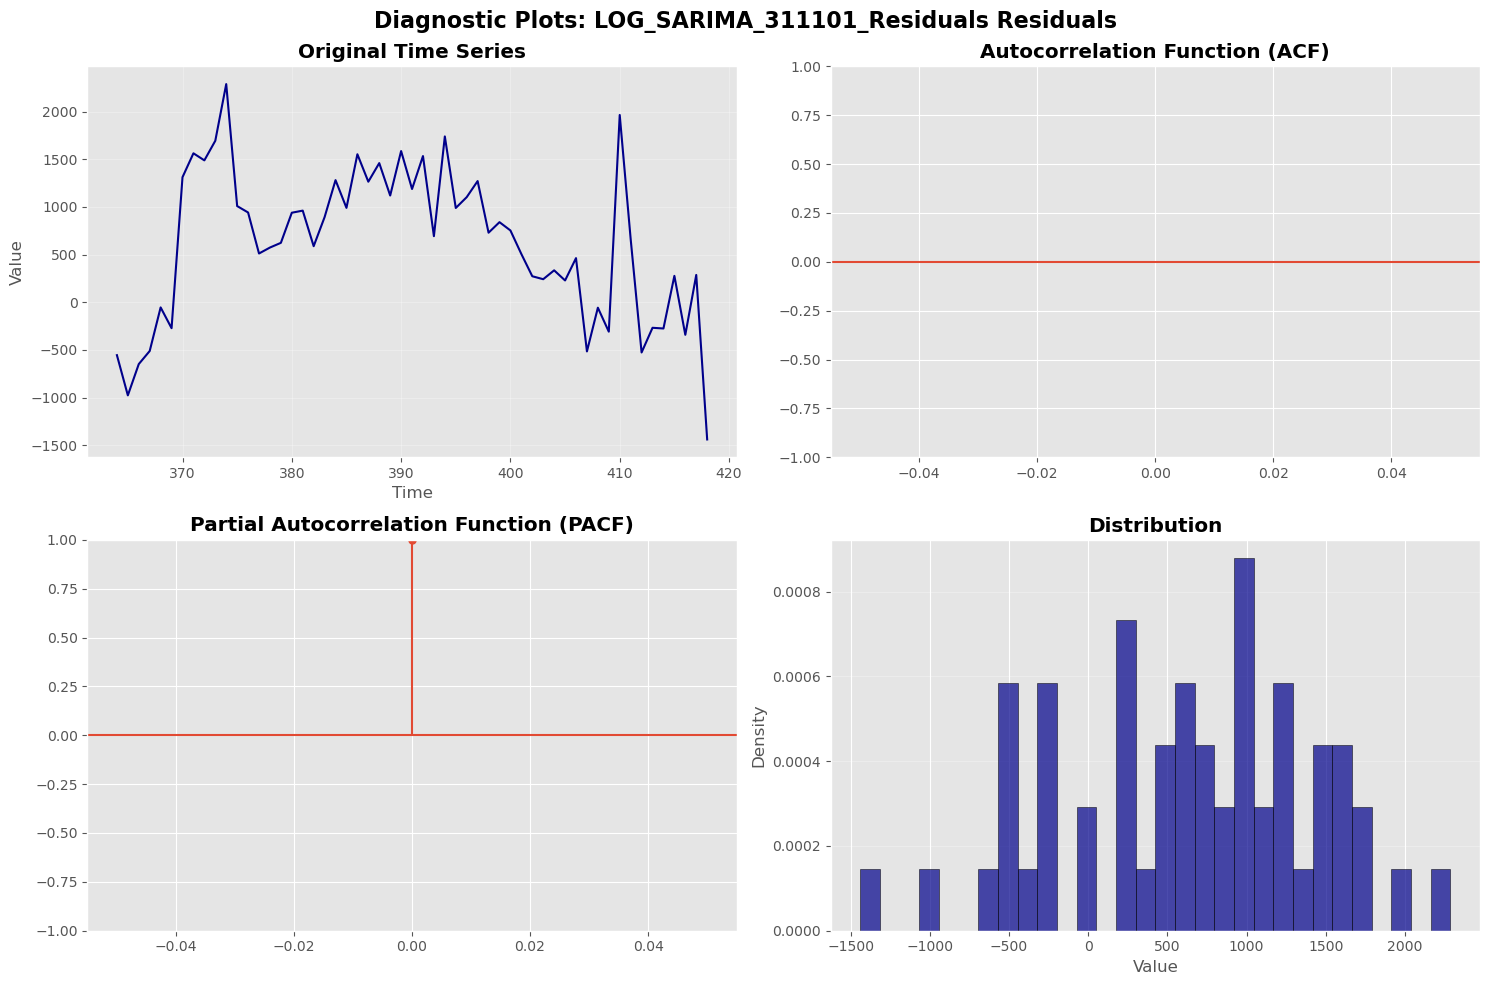

In [218]:
cols = ['ARIMA_212_Residuals', 'ARIMA_211_Residuals', 'LOG_ARIMA_114_Residuals', 'LOG_SARIMA_114101_Residuals', 'LOG_ARIMA_311_Residuals', 'LOG_SARIMA_311101_Residuals']
for col in cols:
    diagnostic_plot(final_data[col], title=f'{col} Residuals')

With only 52 residuals in the test set, the plots are very noisy.